<a href="https://colab.research.google.com/github/rbarkerclarke/HARTDA/blob/main/HARTDA_Clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TDA-HAR Manuscript

* Generate windows
* Generate TDA features
* PCA on topological features
* Run LSTM-CNN models with 5-fold CV




In [1]:
## Load WISDM data
WISDM18=True
WISDM6=False
MAG = True

## Libraries

In [2]:
#!pip install gudhi
import numpy as np
#import gudhi as gd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import clone_model
from tensorflow.keras.utils import to_categorical # Import to_categorical
from sklearn.metrics import precision_score, recall_score, f1_score
#from gtda.homology import CubicalPersistence
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
print(tf.__version__)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

2.19.0


## Load WISDM-18 data

In [3]:
# prompt: download from https://archive.ics.uci.edu/static/public/507/wisdm+smartphone+and+smartwatch+activity+and+biometrics+dataset.zip

!wget https://archive.ics.uci.edu/static/public/507/wisdm+smartphone+and+smartwatch+activity+and+biometrics+dataset.zip
!unzip wisdm+smartphone+and+smartwatch+activity+and+biometrics+dataset.zip
!unzip wisdm-dataset.zip

--2025-08-27 13:57:47--  https://archive.ics.uci.edu/static/public/507/wisdm+smartphone+and+smartwatch+activity+and+biometrics+dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘wisdm+smartphone+and+smartwatch+activity+and+biometrics+dataset.zip’

wisdm+smartphone+an     [                <=> ] 295.92M  1.95MB/s    in 4m 32s  

2025-08-27 14:02:20 (1.09 MB/s) - ‘wisdm+smartphone+and+smartwatch+activity+and+biometrics+dataset.zip’ saved [310292805]

Archive:  wisdm+smartphone+and+smartwatch+activity+and+biometrics+dataset.zip
 extracting: WISDM-dataset-description.pdf  
 extracting: wisdm-dataset.zip       
Archive:  wisdm-dataset.zip
   creating: wisdm-dataset/
  inflating: wisdm-dataset/WISDM-dataset-description.pdf  
   creating: wisdm-dataset/arffmagic-master/
  inflating: wisdm-dataset/

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 12.2 MB/s eta 0:00:00
Persistence diagram: [(0, (0.1, inf)), (0, (0.7, 1.0)), (0, (0.2, 0.5))]


/usr/local/lib/python3.12/dist-packages/gudhi/persistence_graphical_tools.py:129: UserWarning: usetex mode requires TeX.
  warnings.warn("usetex mode requires TeX.")


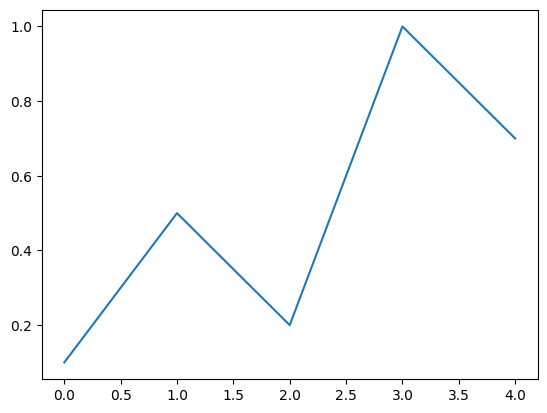

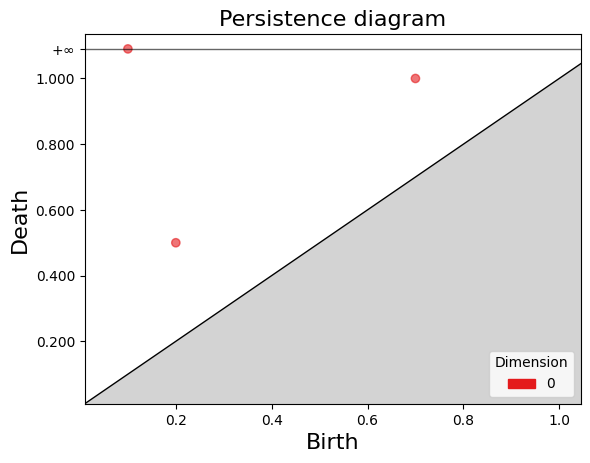

In [4]:
!pip install gudhi
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt

# Example 1D signal
signal = np.array([0.1, 0.5, 0.2, 1.0, 0.7])

# Reshape to 2D grid for CubicalComplex (required input format)
grid = signal[np.newaxis, :]  # shape (1, N)

# Build cubical complex and compute persistence
cc = gd.CubicalComplex(dimensions=grid.shape, top_dimensional_cells=grid.flatten())
cc.compute_persistence()

# Print and plot persistence diagram
diag = cc.persistence()
print("Persistence diagram:", diag)

plt.plot(signal)
gd.plot_persistence_diagram(diag)
plt.show()


## Load WISDM 6

*`Clone`* repository with WISDM 6 data

In [5]:
if WISDM6:
  !git clone https://github.com/aakashratha1006/Human-Activity-Recognition.git

In [6]:
#from gtda.homology import CubicalPersistence
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
print(tf.__version__)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix


2.19.0


In [7]:
from google.colab import drive
#drive.mount('/content/drive')

## Turn WISDM Data into Dataframe

In [8]:
# prompt: full file paths for files in /content/wisdm-dataset/raw/watch/accel only ending in .txt

import glob
print(glob.glob('/content/wisdm-dataset/raw/watch/accel/*.txt'))

['/content/wisdm-dataset/raw/watch/accel/data_1649_accel_watch.txt', '/content/wisdm-dataset/raw/watch/accel/data_1620_accel_watch.txt', '/content/wisdm-dataset/raw/watch/accel/data_1637_accel_watch.txt', '/content/wisdm-dataset/raw/watch/accel/data_1640_accel_watch.txt', '/content/wisdm-dataset/raw/watch/accel/data_1619_accel_watch.txt', '/content/wisdm-dataset/raw/watch/accel/data_1635_accel_watch.txt', '/content/wisdm-dataset/raw/watch/accel/data_1614_accel_watch.txt', '/content/wisdm-dataset/raw/watch/accel/data_1630_accel_watch.txt', '/content/wisdm-dataset/raw/watch/accel/data_1636_accel_watch.txt', '/content/wisdm-dataset/raw/watch/accel/data_1628_accel_watch.txt', '/content/wisdm-dataset/raw/watch/accel/data_1607_accel_watch.txt', '/content/wisdm-dataset/raw/watch/accel/data_1625_accel_watch.txt', '/content/wisdm-dataset/raw/watch/accel/data_1608_accel_watch.txt', '/content/wisdm-dataset/raw/watch/accel/data_1623_accel_watch.txt', '/content/wisdm-dataset/raw/watch/accel/data_16

In [9]:
list_files = glob.glob('/content/wisdm-dataset/raw/watch/accel/*.txt')
list_gyrofiles = glob.glob('/content/wisdm-dataset/raw/watch/gyro/*.txt')

In [10]:
processedList = []

if WISDM18:
  for f in list_files:
    print(f)
    file = open(f)
    lines = file.readlines()

    for i, line in enumerate(lines):
      try:
          line = line.split(',')
          # Ensure there are enough elements before splitting
          if len(line) > 5:
              last = line[5].split(';')[0]
          else:
              # Handle cases where the line doesn't have enough parts
              # For now, we'll skip this line or handle it as an error
              print(f'Error at line number: {i} - Not enough columns')
              continue # Skip to the next line

          last = last.strip()
          if last == '':
              # This condition might be causing it to break prematurely if there's an empty 'last' value
              # Consider if you want to break or skip the line
              # For now, let's skip if it's empty instead of breaking the loop
              print(f'Skipping line number: {i} - Empty last value')
              continue

          # Ensure there are enough elements in the original line list
          if len(line) >= 6:
              temp = [line[0], line[1], line[2], line[3], line[4], last]
              processedList.append(temp)
          else:
              print(f'Error at line number: {i} - Not enough columns after split')

      except Exception as e:
          print(f'Error at line number: {i} - {e}')

# Now you can process processedList or convert it to a DataFrame
# For example:
# df = pd.DataFrame(processedList, columns=['user', 'activity', 'timestamp', 'x', 'y', 'z'])
# print(df.head())
# print(len(processedList))
# print(len(lines))


/content/wisdm-dataset/raw/watch/accel/data_1649_accel_watch.txt
/content/wisdm-dataset/raw/watch/accel/data_1620_accel_watch.txt
/content/wisdm-dataset/raw/watch/accel/data_1637_accel_watch.txt
/content/wisdm-dataset/raw/watch/accel/data_1640_accel_watch.txt
/content/wisdm-dataset/raw/watch/accel/data_1619_accel_watch.txt
/content/wisdm-dataset/raw/watch/accel/data_1635_accel_watch.txt
/content/wisdm-dataset/raw/watch/accel/data_1614_accel_watch.txt
/content/wisdm-dataset/raw/watch/accel/data_1630_accel_watch.txt
/content/wisdm-dataset/raw/watch/accel/data_1636_accel_watch.txt
/content/wisdm-dataset/raw/watch/accel/data_1628_accel_watch.txt
/content/wisdm-dataset/raw/watch/accel/data_1607_accel_watch.txt
/content/wisdm-dataset/raw/watch/accel/data_1625_accel_watch.txt
/content/wisdm-dataset/raw/watch/accel/data_1608_accel_watch.txt
/content/wisdm-dataset/raw/watch/accel/data_1623_accel_watch.txt
/content/wisdm-dataset/raw/watch/accel/data_1641_accel_watch.txt
/content/wisdm-dataset/ra

In [11]:
processedList_gyro = []

if WISDM18:
  for f in list_gyrofiles:
    print(f)
    file = open(f)
    lines = file.readlines()

    for i, line in enumerate(lines):
      try:
          line = line.split(',')
          # Ensure there are enough elements before splitting
          if len(line) > 5:
              last = line[5].split(';')[0]
          else:
              # Handle cases where the line doesn't have enough parts
              # For now, we'll skip this line or handle it as an error
              print(f'Error at line number: {i} - Not enough columns')
              continue # Skip to the next line

          last = last.strip()
          if last == '':
              # This condition might be causing it to break prematurely if there's an empty 'last' value
              # Consider if you want to break or skip the line
              # For now, let's skip if it's empty instead of breaking the loop
              print(f'Skipping line number: {i} - Empty last value')
              continue

          # Ensure there are enough elements in the original line list
          if len(line) >= 6:
              temp = [line[0], line[1], line[2], line[3], line[4], last]
              processedList_gyro.append(temp)
          else:
              print(f'Error at line number: {i} - Not enough columns after split')

      except Exception as e:
          print(f'Error at line number: {i} - {e}')

# Now you can process processedList or convert it to a DataFrame
# For example:
# df = pd.DataFrame(processedList, columns=['user', 'activity', 'timestamp', 'x', 'y', 'z'])
# print(df.head())
# print(len(processedList))
# print(len(lines))


/content/wisdm-dataset/raw/watch/gyro/data_1608_gyro_watch.txt
/content/wisdm-dataset/raw/watch/gyro/data_1620_gyro_watch.txt
/content/wisdm-dataset/raw/watch/gyro/data_1644_gyro_watch.txt
/content/wisdm-dataset/raw/watch/gyro/data_1639_gyro_watch.txt
/content/wisdm-dataset/raw/watch/gyro/data_1625_gyro_watch.txt
/content/wisdm-dataset/raw/watch/gyro/data_1632_gyro_watch.txt
/content/wisdm-dataset/raw/watch/gyro/data_1635_gyro_watch.txt
/content/wisdm-dataset/raw/watch/gyro/data_1621_gyro_watch.txt
/content/wisdm-dataset/raw/watch/gyro/data_1643_gyro_watch.txt
/content/wisdm-dataset/raw/watch/gyro/data_1603_gyro_watch.txt
/content/wisdm-dataset/raw/watch/gyro/data_1611_gyro_watch.txt
/content/wisdm-dataset/raw/watch/gyro/data_1636_gyro_watch.txt
/content/wisdm-dataset/raw/watch/gyro/data_1650_gyro_watch.txt
/content/wisdm-dataset/raw/watch/gyro/data_1610_gyro_watch.txt
/content/wisdm-dataset/raw/watch/gyro/data_1633_gyro_watch.txt
/content/wisdm-dataset/raw/watch/gyro/data_1606_gyro_wa

In [12]:
import pandas as pd

if WISDM18:

  df_gyro = pd.DataFrame(processedList_gyro, columns=['user', 'activity', 'timestamp', 'x', 'y', 'z'])
  print(df_gyro.sort_values('timestamp').head())
  print(len(processedList_gyro))
  print(len(lines))

  df_accel = pd.DataFrame(processedList, columns=['user', 'activity', 'timestamp', 'x', 'y', 'z'])
  print(df_accel.sort_values('timestamp').head())
  print(len(processedList))
  print(len(lines))

  df = pd.merge(
    left=df_accel,
    right=df_gyro,
    how='left',
    left_on=['user', 'timestamp', 'activity'],
    right_on=['user', 'timestamp', 'activity'],  suffixes=('_accel', '_gyro'),
  )

  df.drop_duplicates(inplace=True, keep='first')




         user activity       timestamp            x            y            z
2135695  1605        A  10000020335529  -0.96056116  -0.17924778   -1.0392797
2135696  1605        A  10000070303271   -1.0851971  -0.16752988   -0.8890774
2135697  1605        A  10000120249425  -0.19783185  -0.09083084  -0.70904773
2135698  1605        A  10000170187569   0.32947403  0.070024095  -0.20517765
2135699  1605        A  10000220141181   0.21655601   0.27135906   0.17618701
3440342
64833
         user activity       timestamp          x           y            z
3582154  1605        A  10000020335529  13.407081  -3.3331776   0.24181437
3582155  1605        A  10000070303271  10.553192  -5.5502086    1.0702082
3582156  1605        A  10000120249425  11.091887  -3.9365165   -0.4309563
3582157  1605        A  10000170187569  12.384756  -3.5606267   -0.2801216
3582158  1605        A  10000220141181   9.837326  -3.6947021  -0.21787235
3777046
64833


## WISDM6 Activity Data Loading

In [13]:

if WISDM6:
  file = open('/content/Human-Activity-Recognition/Dataset/WISDM_ar_v1.1_raw.txt')
  lines = file.readlines()

  processedList = []

  for i, line in enumerate(lines):
    try:
        line = line.split(',')
        # Ensure there are enough elements before splitting
        if len(line) > 5:
            last = line[5].split(';')[0]
        else:
            # Handle cases where the line doesn't have enough parts
            # For now, we'll skip this line or handle it as an error
            print(f'Error at line number: {i} - Not enough columns')
            continue # Skip to the next line

        last = last.strip()
        if last == '':
            # This condition might be causing it to break prematurely if there's an empty 'last' value
            # Consider if you want to break or skip the line
            # For now, let's skip if it's empty instead of breaking the loop
            print(f'Skipping line number: {i} - Empty last value')
            continue

        # Ensure there are enough elements in the original line list
        if len(line) >= 6:
             temp = [line[0], line[1], line[2], line[3], line[4], last]
             processedList.append(temp)
        else:
            print(f'Error at line number: {i} - Not enough columns after split')

    except Exception as e:
        print(f'Error at line number: {i} - {e}')


## Pre-process any data

In [14]:
if WISDM18:
  columns = ['user', 'activity', 'time', 'x_accel', 'y_accel', 'z_accel', 'x_gyro','y_gyro', 'z_gyro']
  data = df
  data.columns = columns
  # Data to Float, Drop NA
  data['x_accel'] = data['x_accel'].astype('float')
  data['y_accel'] = data['y_accel'].astype('float')
  data['z_accel'] = data['z_accel'].astype('float')
  data['x_gyro'] = data['x_gyro'].astype('float')
  data['y_gyro'] = data['y_gyro'].astype('float')
  data['z_gyro'] = data['z_gyro'].astype('float')
  data.dropna(inplace=True)

if WISDM6:
  columns = ['user', 'activity', 'time', 'x', 'y', 'z', 'magnitude']
  data = pd.DataFrame(data = processedList, columns = columns[:-1])

from sklearn.preprocessing import LabelEncoder
label2 = LabelEncoder()
data['label'] = label2.fit_transform(data['activity'])

label2.classes_


array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'O', 'P', 'Q', 'R', 'S'], dtype=object)

# Plot activity examples

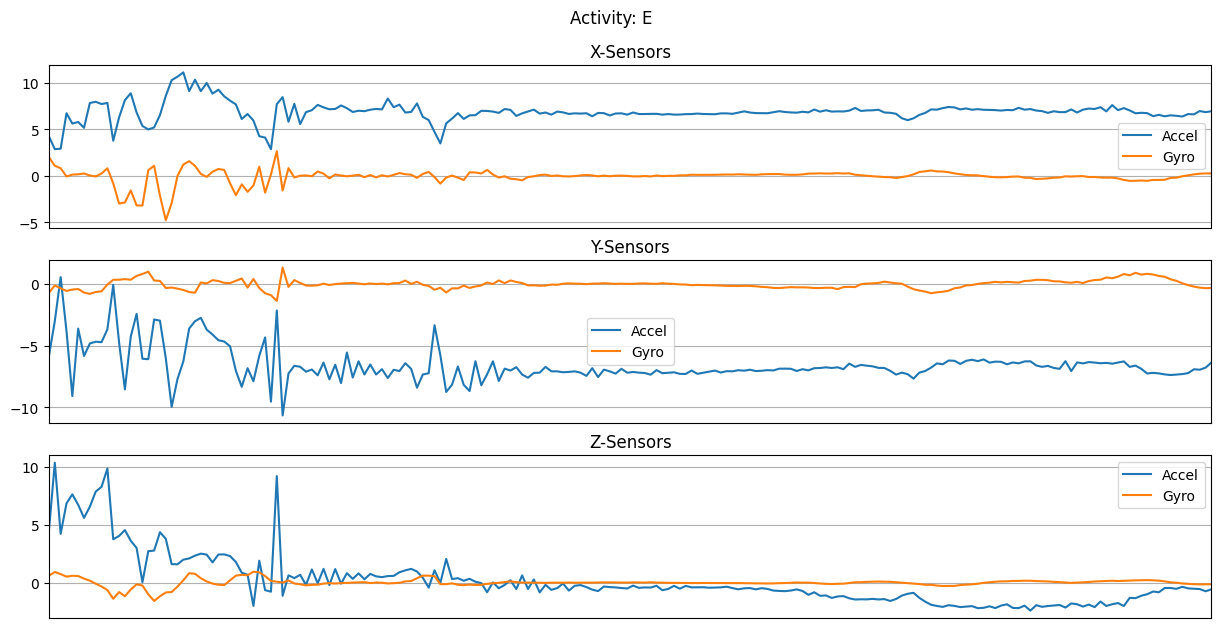

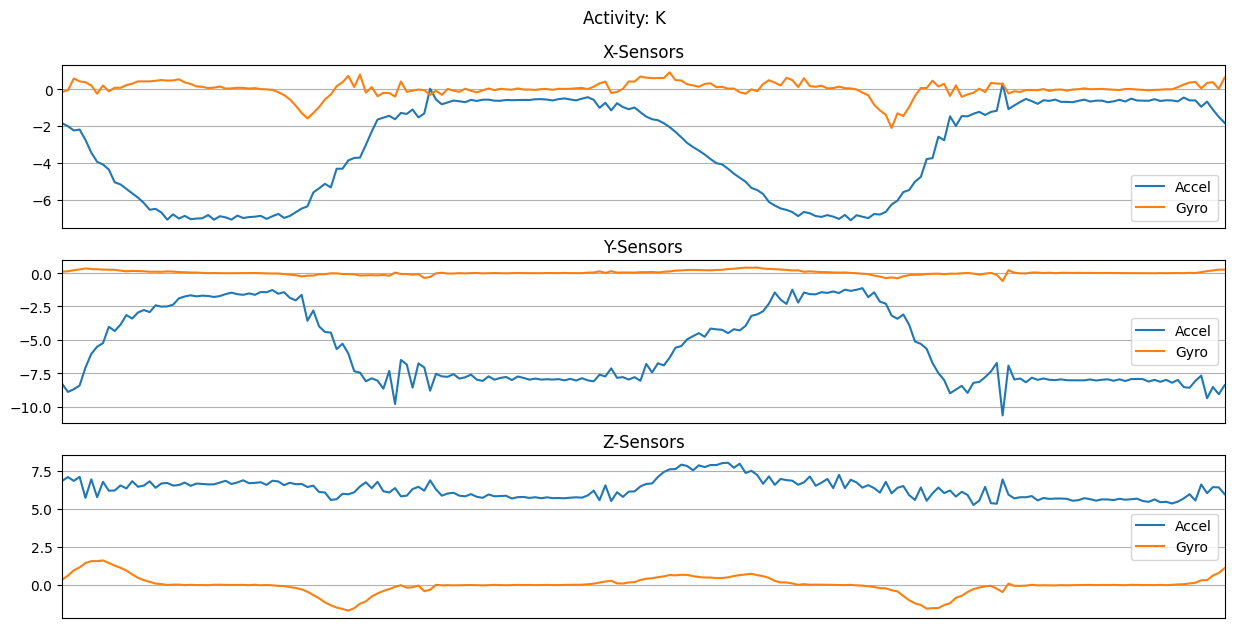

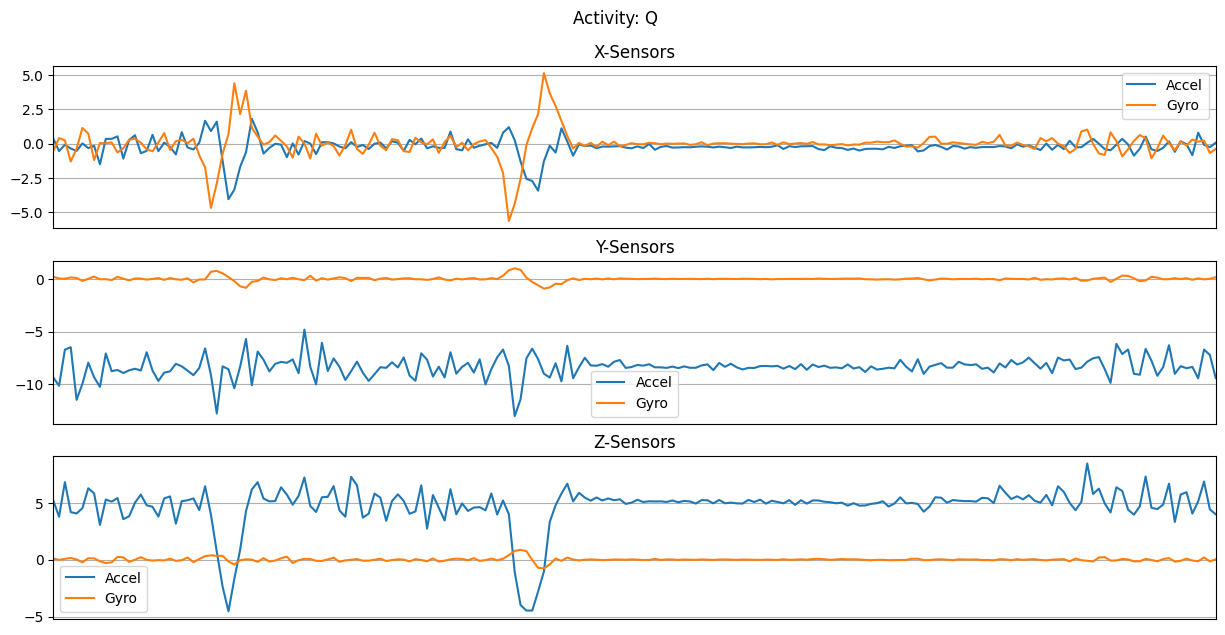

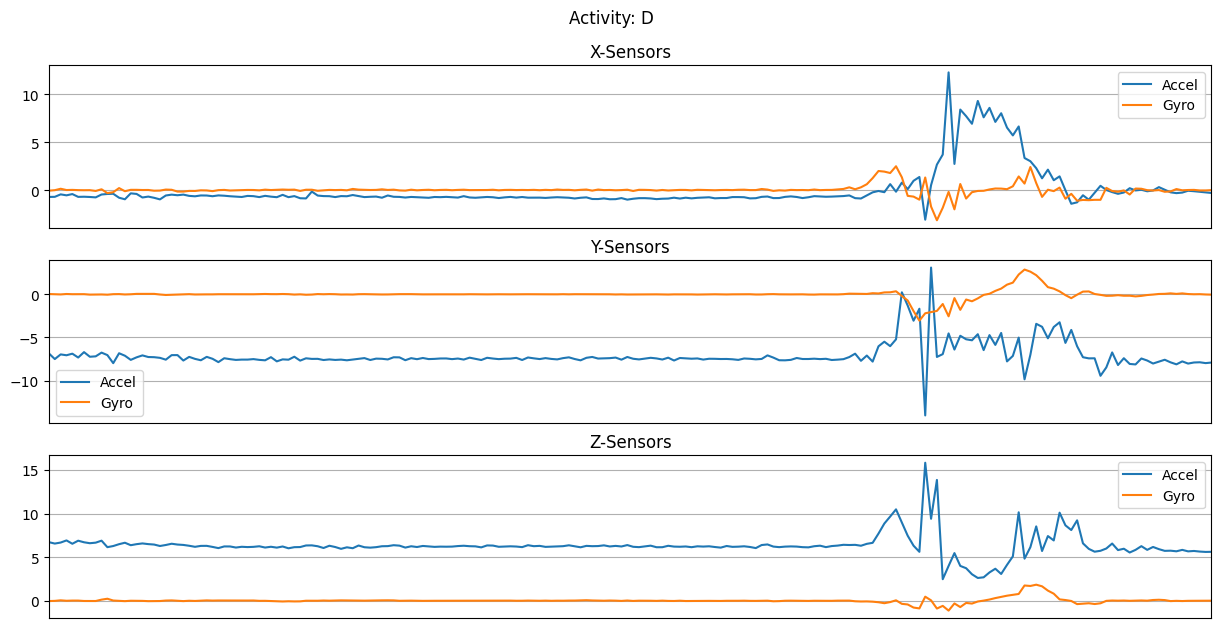

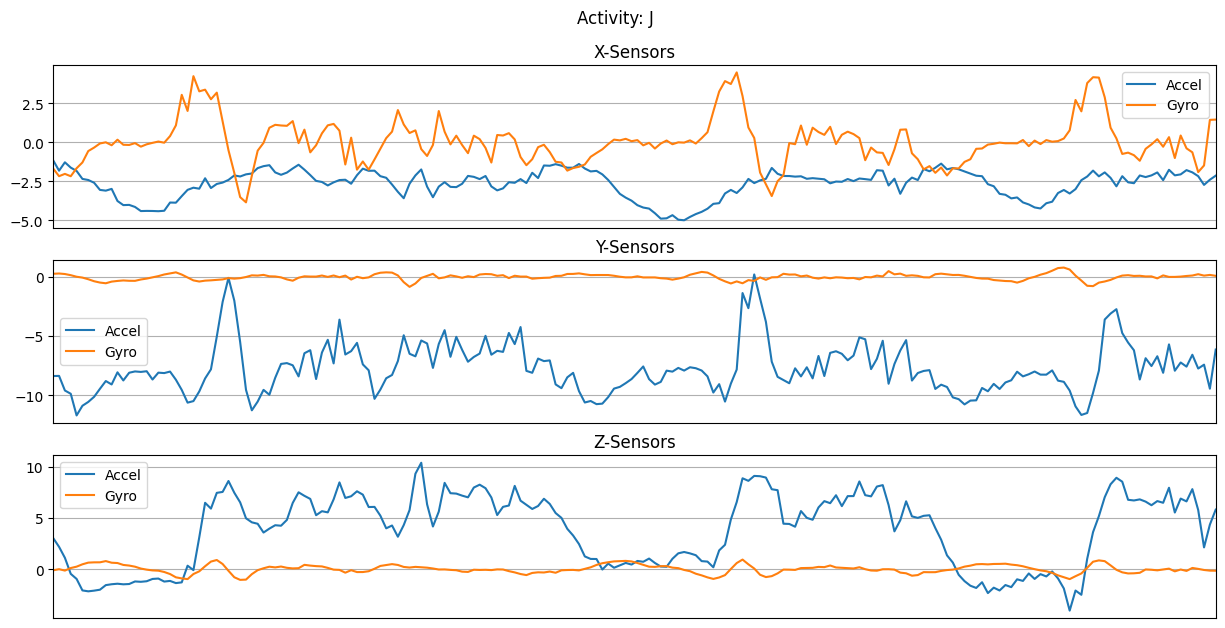

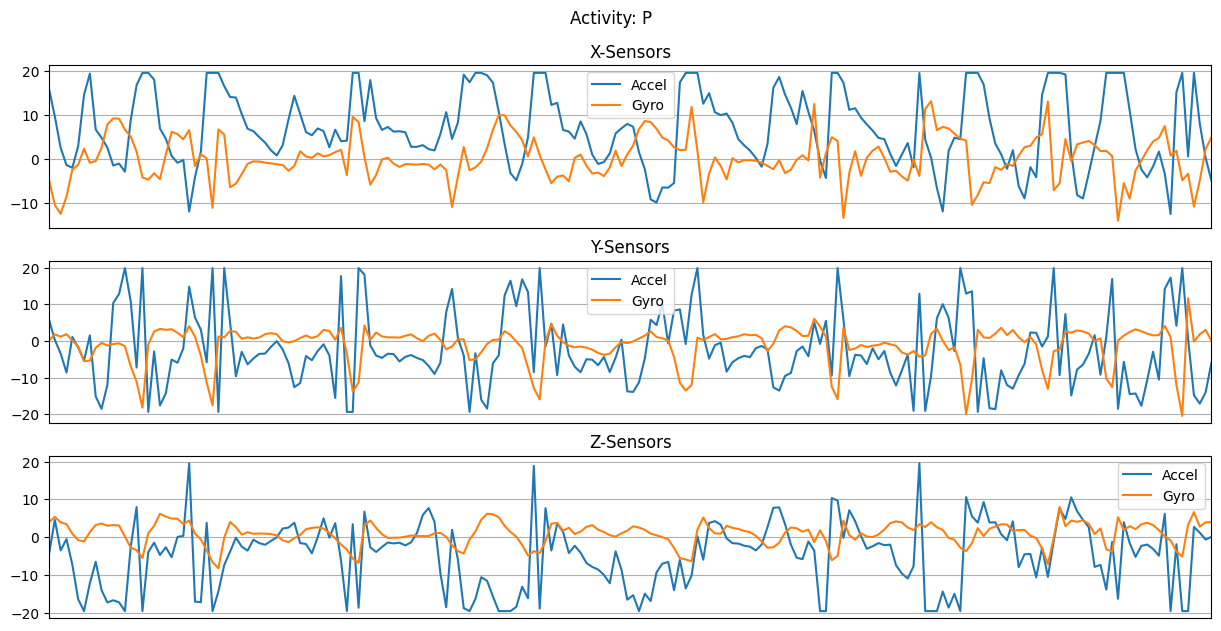

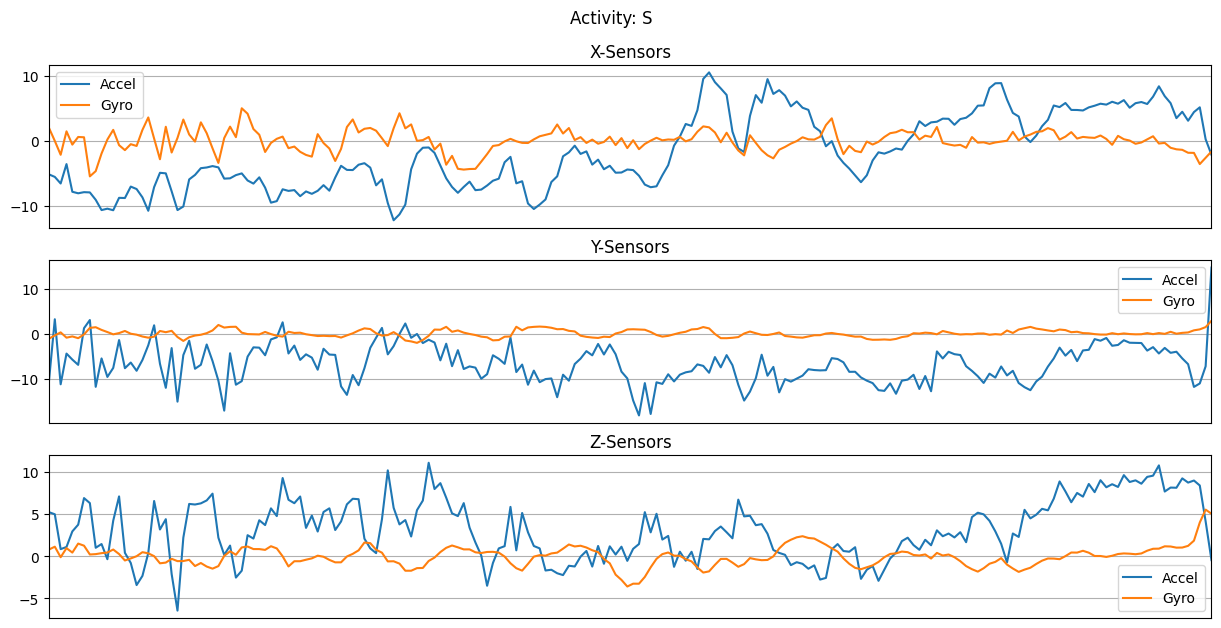

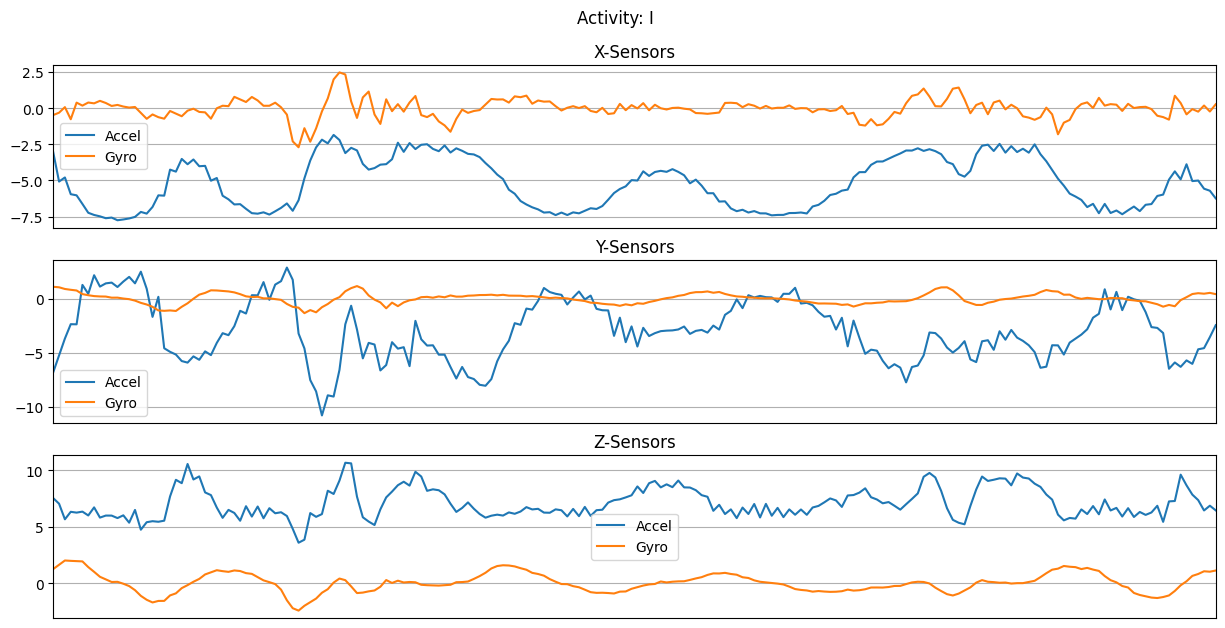

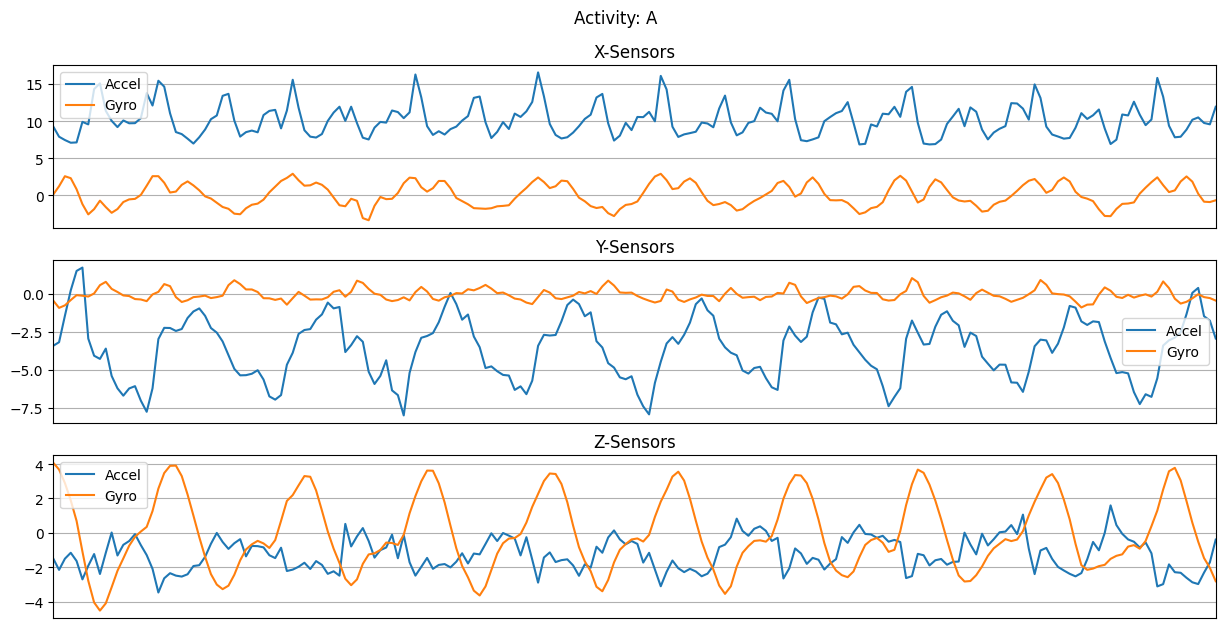

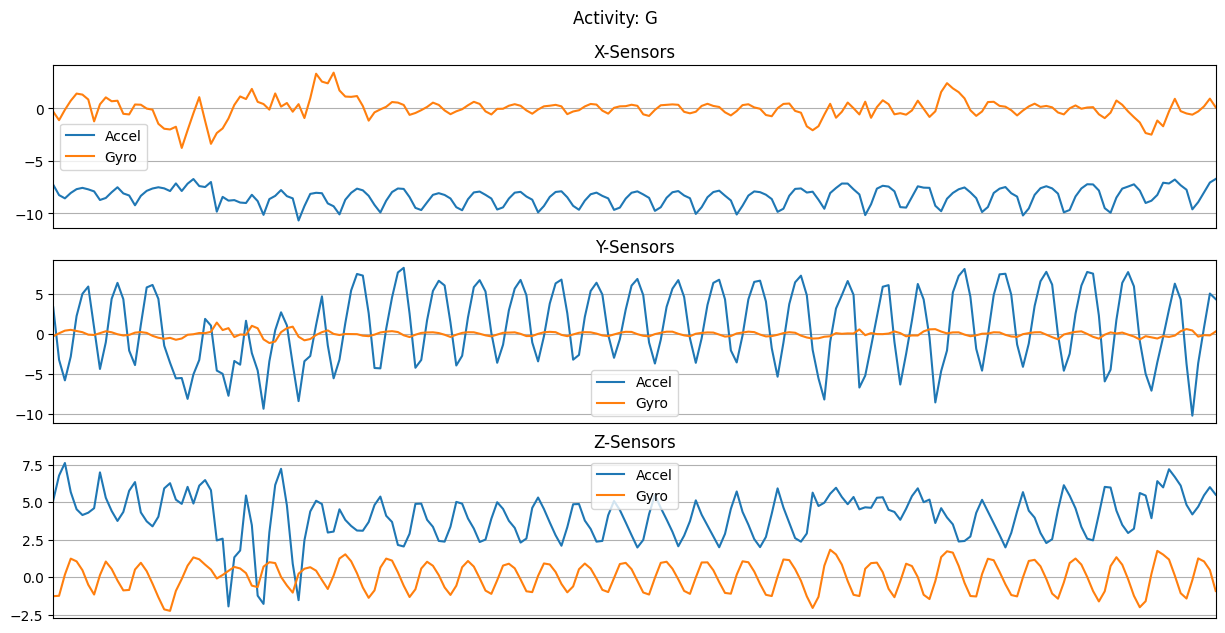

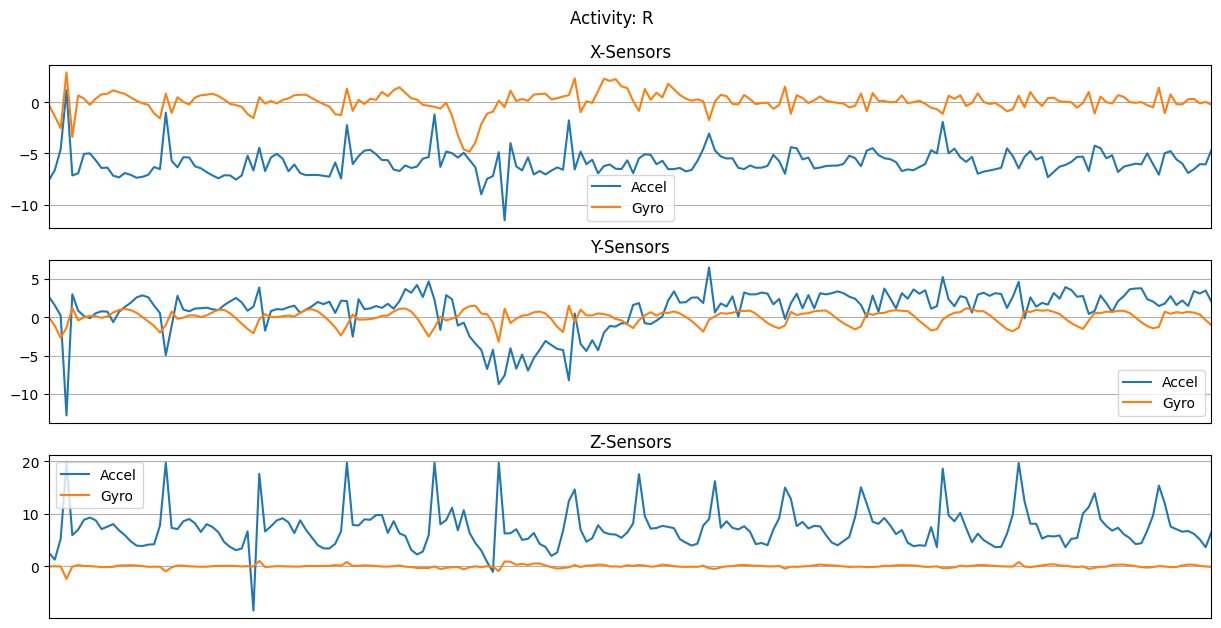

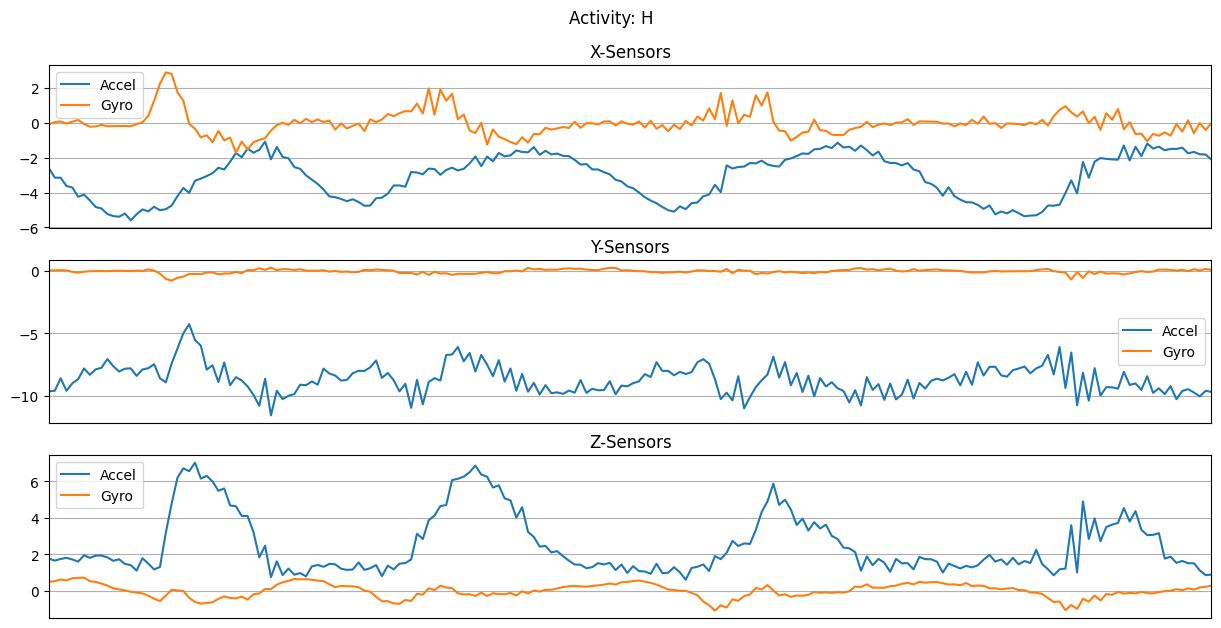

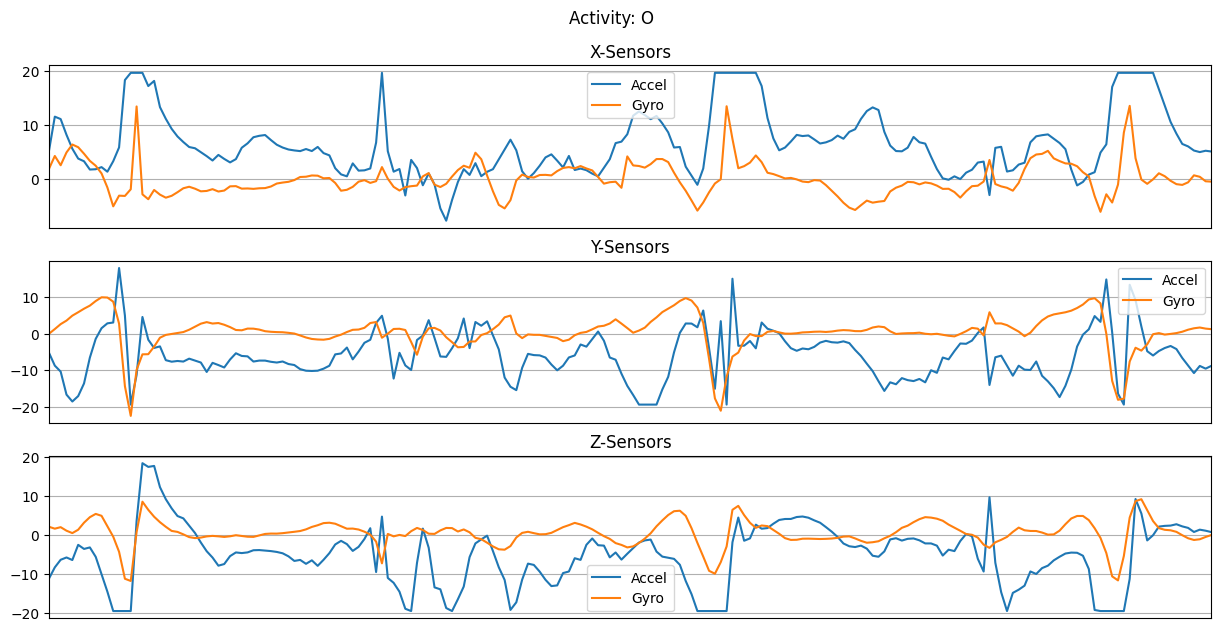

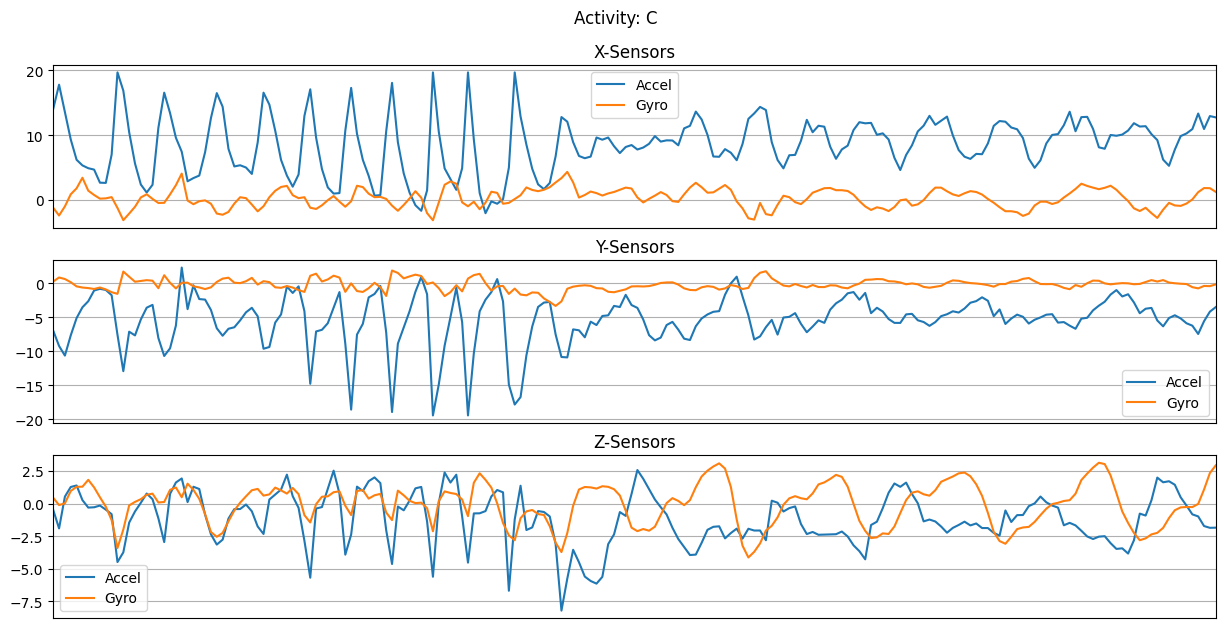

In [15]:
import matplotlib.pyplot as plt
import numpy as np

if WISDM18:

  def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
    plot_axis(ax0, data['time'], data['x_accel'],  data['x_gyro'], title='X-Sensors')
    plot_axis(ax1, data['time'], data['y_accel'],  data['y_gyro'], title='Y-Sensors')
    plot_axis(ax2, data['time'], data['z_accel'],  data['z_gyro'], title='Z-Sensors')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle("Activity: " + activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

  def plot_axis(ax, x, y,y2, title):
    ax.plot(x, y, label='Accel')
    ax.plot(x, y2, label='Gyro')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_xlim([min(x), max(x)])
    #ax.set_ylim([min(y,y2) - np.std(y), max(y,y2) + np.std(y)])
    ax.legend()
    ax.grid(True)

if WISDM6:
  def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
    plot_axis(ax0, data['time'], data['x'], title='X-Sensors')
    plot_axis(ax1, data['time'], data['y'], title='Y-Sensors')
    plot_axis(ax2, data['time'], data['z'], title='Z-Sensors')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle("Activity: " + activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

  def plot_axis(ax, x, y, title):
    ax.plot(x, y, label='Accel')
    #ax.plot(x, y2, label='Gyro')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_xlim([min(x), max(x)])
    #ax.set_ylim([min(y,y2) - np.std(y), max(y,y2) + np.std(y)])
    ax.legend()
    ax.grid(True)

Fs = 20 #Frame Size?

activities = data['activity'].value_counts().index
activities

for activity in activities:
    data_for_plot = data[(data['activity'] == activity)][:Fs*10]
    plot_activity(activity, data_for_plot)

### Balance Activities (6 Activity Set)

In [16]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
data['label'] = label.fit_transform(data['activity'])
data.head()

if WISDM6:
  df = data.drop(['time'], axis = 1).copy()
  Walking = df[df['activity']=='Walking'].copy()
  Jogging = df[df['activity']=='Jogging'].copy()
  Upstairs = df[df['activity']=='Upstairs'].copy()
  Downstairs = df[df['activity']=='Downstairs'].copy()
  Sitting = df[df['activity']=='Sitting'].copy()
  Standing = df[df['activity']=='Standing'].copy()
  #Sitting = df[df['activity']=='Sitting'].head(3555).copy()
  #Standing = df[df['activity']=='Standing'].copy()
  # Use pd.concat() to combine the DataFrames
  balanced_data = pd.concat([Walking, Jogging, Upstairs, Downstairs, Sitting, Standing], ignore_index=True)
  #balanced_data = pd.concat([Walking, Jogging, Upstairs, Downstairs], ignore_index=True)

  balanced_data.shape
  balanced_data['activity'].value_counts()
  # Standardizing data
  group = balanced_data['user']
  X = balanced_data[['x', 'y', 'z']]
  y = balanced_data['label']


In [17]:
data.head()

user activity              time   x_accel   y_accel   z_accel    x_gyro  \
1  1649        A  2723190229338443  9.267506 -3.425654 -1.491288  0.092216   
2  1649        A  2723190278838443  7.890840 -3.188628 -2.152088  1.213939   
3  1649        A  2723190328338443  7.443124 -1.450437 -1.503259  2.565760   
4  1649        A  2723190377838443  7.079205  0.218321 -1.158494  2.300509   
5  1649        A  2723190427338443  7.122301  1.499219 -1.637335  0.805943   

     y_gyro    z_gyro  label  
1 -0.452995  4.077074      0  
2 -0.932364  3.682926      0  
3 -0.766183  2.896761      0  
4 -0.416776  1.890086      0  
5 -0.095066  0.691663      0




# Add magnitude vectors


In [18]:
MAG

True

In [19]:
# Frame preparation
import scipy.stats as stats
Fs = 20
frame_size = 200 # 80
hop_size = 100 # 40
df= data

# Update columns and re-process the data
if WISDM6:
  columns = ['user', 'activity', 'time', 'x', 'y', 'z', 'magnitude']
  #data = pd.DataFrame(data = processedList, columns = columns[:-1]) # Recreate data from processedList initially without magnitude

  # Convert 'x', 'y', and 'z' columns to float *before* calculating magnitude
  data['x'] = [float(i) for i in data['x']]
  data['z'] = [float(i) for i in data['z']]
  data['y'] = [float(i) for i in data['y']]

  # Calculate the magnitude using x y z
  data['magnitude'] = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2)
  data.head()


# Update columns and re-process the data
if WISDM18:
  columns = ['user', 'activity', 'time', 'x_accel',	'y_accel',	'z_accel','m_a',	'x_gyro',	'y_gyro','z_gyro','m_g','label']
  #data = pd.DataFrame(data = processedList, columns = columns[:-1]) # Recreate data from processedList initially without magnitude

  # Convert 'x', 'y', and 'z' columns to float *before* calculating magnitude
  data['x_accel'] = [float(i) for i in data['x_accel']]
  data['z_accel'] = [float(i) for i in data['z_accel']]
  data['y_accel'] = [float(i) for i in data['y_accel']]
  data['x_gyro'] = [float(i) for i in data['x_gyro']]
  data['z_gyro'] = [float(i) for i in data['z_gyro']]
  data['y_gyro'] = [float(i) for i in data['y_gyro']]

  # Calculate the magnitude using x y z
  data['m_a'] = np.sqrt(data['x_accel']**2 + data['y_accel']**2 + data['z_accel']**2)
  data['m_g'] = np.sqrt(data['x_gyro']**2 + data['y_gyro']**2 + data['z_gyro']**2)
  data.head()

# prompt: generate get_frames but only keep frames if df['label'] has only one unique value
if MAG == True & WISDM18:
  def get_frames(df, frame_size, hop_size):

    N_FEATURES = len(['x_a', 'y_a', 'z_a', 'm_a','x_g', 'y_g', 'z_g', 'm_g'])

    frames = []
    labels = []
    users=[]
    for i in range(0, len(df) - frame_size, hop_size):
        segment_df = df[i: i + frame_size]
        # Check if the 'label' column in the segment has only one unique value
        if segment_df['label'].nunique() == 1:
            x_a = segment_df['x_accel'].values
            y_a = segment_df['y_accel'].values
            z_a = segment_df['z_accel'].values
            x_g = segment_df['x_gyro'].values
            y_g = segment_df['y_gyro'].values
            z_g = segment_df['z_gyro'].values
            m_a = segment_df['m_a'].values
            m_g = segment_df['m_g'].values

            label = segment_df['label'].iloc[0] # Since there's only one unique label
            user = segment_df['user'].iloc[0] # Since there's only one unique label

            frames.append([x_a, y_a, z_a, m_a, x_g, y_g, z_g, m_g])
            labels.append(label)
            users.append(user)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)
    users = np.asarray(users)

    return frames, labels, users

if MAG == True & WISDM6:
  def get_frames(df, frame_size, hop_size):

    N_FEATURES = len(['x', 'y', 'z', 'mag'])

    frames = []
    labels = []
    users=[]
    for i in range(0, len(df) - frame_size, hop_size):
        segment_df = df[i: i + frame_size]
        # Check if the 'label' column in the segment has only one unique value
        if segment_df['label'].nunique() == 1:
            x_a = segment_df['x'].values
            y_a = segment_df['y'].values
            z_a = segment_df['z'].values
            m = segment_df['magnitude'].values


            label = segment_df['label'].iloc[0] # Since there's only one unique label
            user = segment_df['user'].iloc[0] # Since there's only one unique label

            frames.append([x_a, y_a, z_a, m])
            labels.append(label)
            users.append(user)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)
    users = np.asarray(users)

    return frames, labels, users



In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X, y, users = get_frames(data, frame_size, hop_size)
print(X.shape, y.shape, users.shape)
# Get unique users
unique_users = np.unique(users)

if True:
  # Split users into train, validation, and test sets
  train_users, temp_users = train_test_split(unique_users, test_size=0.3, random_state=42) #42
  val_users, test_users = train_test_split(temp_users, test_size=0.5, random_state=42) #42

  # Create masks for each set
  train_mask = np.isin(users, train_users)
  val_mask = np.isin(users, val_users)
  test_mask = np.isin(users, test_users)

  # Apply masks to the data
  X_train, y_train = X[train_mask], y[train_mask]
  X_val, y_val = X[val_mask], y[val_mask]
  X_test, y_test = X[test_mask], y[test_mask]

  print("X_train shape:", X_train.shape)
  print("y_train shape:", y_train.shape)
  print("X_val shape:", X_val.shape)
  print("y_val shape:", y_val.shape)
  print("X_test shape:", X_test.shape)
  print("y_test shape:", y_test.shape)

scale = False

if scale:
  scaler = StandardScaler()
  X_reshaped = X.reshape((-1,1))
  print(X_reshaped.shape)
  X_scaled = scaler.fit_transform(X_reshaped)
  X_scaled_reshaped = X_scaled.reshape(X.shape)
  print(X_scaled_reshaped.shape)

  # Reshape the scaled data back to the original 3D shape (n_frames, frame_size, n_features)
  X = X_scaled_reshaped.reshape(X.shape[0], X.shape[1], X.shape[2])



(29955, 200, 8) (29955,) (29955,)
X_train shape: (20398, 200, 8)
y_train shape: (20398,)
X_val shape: (4996, 200, 8)
y_val shape: (4996,)
X_test shape: (4561, 200, 8)
y_test shape: (4561,)


# Learning Curve Function

In [21]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

In [22]:
if MAG==False:
  if WISDM6:
    Nax= 3  # 3 sensor axes (3x1)
  elif WISDM18:
    Nax= 6  # 6 sensor axes (3x2)
  X_train = X_train.reshape(X_train.shape[0], frame_size, Nax, 1)
  X_test = X_test.reshape(X_test.shape[0], frame_size, Nax, 1)
  X_val = X_val.reshape(X_val.shape[0], frame_size, Nax, 1)

# Add magnitude vector (Start here)


## Magnitude for 6 axes (18 activities)

In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Compute magnitude channels
# -------------------------------

X, y, users = get_frames(data, frame_size, hop_size)
print("Raw X shape:", X.shape)

np.save("wisdm18/X.npy", X)
np.save("wisdm18/y.npy", y)
np.save("wisdm18/users.npy", users)

Raw X shape: (29955, 200, 8)


# Add PH Features

### 6D guhdi rips

In [25]:
if WISDM18:
  N_sensors =2

if WISDM6:
  N_sensors = 1


In [27]:
#~6 mins to run
#~4 mins in better environment (no explicit CPU/GPU speed up)
import numpy as np
from gudhi import RipsComplex
from gudhi import persistence_graphical_tools as pg_tools
import scipy.stats
from scipy.stats import skew
from tqdm import tqdm
import numpy as np
from gudhi import RipsComplex
from scipy.stats import skew

import cupy as cp
#from cupyx.scipy.stats import skew


def calculate_skewness_cupy(data):
    """Calculates skewness for a CuPy array."""
    mean = cp.mean(data)
    std_dev = cp.std(data)
    n = data.size

    # Calculate the third central moment
    third_moment = cp.sum((data - mean)**3) / n

    # Calculate skewness
    skewness = third_moment / (std_dev**3)
    return skewness

# Example usage:
gpu_array = cp.random.rand(100)
skewness_value = calculate_skewness_cupy(gpu_array)
print(f"Skewness: {skewness_value}")

def extract_stats_gpu(diagram):
    births = cp.asarray(diagram[:, 0])
    deaths = cp.asarray(diagram[:, 1])
    persistence = deaths - births

    skew_birth = calculate_skewness_cupy(births).item() if len(births) > 2 else 0.0
    skew_death = calculate_skewness_cupy(deaths).item() if len(deaths) > 2 else 0.0

    if len(births) > 1:
        cov = cp.cov(births, deaths)[0, 1].item()
        corr = cp.corrcoef(births, deaths)[0, 1].item()
    else:
        cov = 0.0
        corr = 0.0

    return [
        persistence.mean().item(),
        persistence.std().item(),
        persistence.max().item(),
        persistence.sum().item(),
        len(persistence),
        births.mean().item(),
        deaths.mean().item(),
        births.std().item(),
        deaths.std().item(),
        births.max().item(),
        deaths.max().item(),
        skew_birth,
        skew_death,
        cov,
        corr
    ]


def extract_stats(diagram):
    """Extracts persistence statistics from a given persistence diagram."""
    births = diagram[:, 0]
    deaths = diagram[:, 1]
    persistence = deaths - births

    skew_birth = skew(births) if len(births) > 2 else 0.0
    skew_death = skew(deaths) if len(deaths) > 2 else 0.0

    # Covariance and correlation
    if len(births) > 1:
        cov = np.cov(births, deaths)[0, 1]
        corr = np.corrcoef(births, deaths)[0, 1]
    else:
        cov = 0.0
        corr = 0.0

    return [
        np.mean(persistence),
        np.std(persistence),
        np.max(persistence),
        np.sum(persistence),
        len(persistence),
        np.mean(births),
        np.mean(deaths),
        np.std(births),
        np.std(deaths),
        np.max(births),
        np.max(deaths),
        skew_birth,
        skew_death,
        cov,
        corr
    ]

def compute_persistence_features_rips(frames):
    """
    Computes 0D and 1D Vietoris-Rips persistence features using GUDHI for each frame.

    Args:
        frames (np.ndarray): Input of shape (n_frames, frame_size, total_dims) where total_dims = N_sensors*3 + 2

    Returns:
        np.ndarray: (n_frames, N_sensors * n_dims * n_features)
    """
    n_frames, frame_size, n_dim = frames.shape
    assert n_dim == N_sensors * 3 + N_sensors, f"Expected input with {N_sensors * 3 + N_sensors} features, got {n_dim}"

    all_persistence_features = []

    for frame in tqdm(frames):
        frame_features = []

        for sensor in range(N_sensors):
            #Excludes magnitudes if present
            sensor_frame = frame[:, 3 * sensor : 3 * (sensor + 1)]  # shape (frame_size, 3)

            rips_complex = RipsComplex(points=sensor_frame, max_edge_length=2.0)
            simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)
            diag = simplex_tree.persistence()

            # Extract persistence diagrams by dimension
            diagram_0d = np.array([pair[1] for pair in diag if pair[0] == 0 and pair[1][1] != float('inf')])
            diagram_1d = np.array([pair[1] for pair in diag if pair[0] == 1 and pair[1][1] != float('inf')])

            features_0d = extract_stats(diagram_0d) if diagram_0d.size > 0 else [0.0] * 15
            features_1d = extract_stats(diagram_1d) if diagram_1d.size > 0 else [0.0] * 15

            # Concatenate all features for this sensor
            frame_features.extend(features_0d + features_1d)

        all_persistence_features.append(frame_features)

    return np.array(all_persistence_features)


# Assuming X_train and X_test are your frame data (n_samples, frame_size, n_features)
# Before calling, ensure X_train and X_test are 3D arrays
# X_train from previous code has shape (n_samples, 80, 3, 1). Squeeze the last dimension.
X_squeezed = X.squeeze()

# Compute 0D persistence features
X_persistance_all = compute_persistence_features_rips(X_squeezed)

print("X_persistance_all shape:", X_persistance_all.shape)

Skewness: -0.13081388782032977


  0%|          | 0/29955 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|██████████| 29955/29955 [03:50<00:00, 129.86it/s]

X_persistance_all shape: (29955, 60)


In [50]:
accel_only = False
if accel_only:
  X_persistence_all_accel = X_persistence_all[:,:30]

!pip install gudhi
import gudhi

# Add Cubical Features

In [51]:
from joblib import Parallel, delayed

selected_channels = [0, 1, 2, 3, 4,5,6,7]

def process_channel(frame, ch, max_dim, stats_funcs, stat_names, feature_names_ref):
    frame_persistence_stats = []
    signal = np.ascontiguousarray(frame[:, ch].astype(np.float32))
    cubical_complex = gudhi.CubicalComplex(
    dimensions=[signal.shape[0]],
    top_dimensional_cells=signal
    )
    try:
        persistence = cubical_complex.persistence()
    except Exception:
        return [0] * (1 + (len(stat_names) - 1) * 3) * (max_dim + 1), feature_names_ref

    diagrams_by_dim = {dim: [] for dim in range(max_dim + 1)}
    for dim, bd in persistence:
        if dim <= max_dim:
            diagrams_by_dim[dim].append(bd)

    for dim in range(max_dim + 1):
        diagram_array = np.array(diagrams_by_dim.get(dim, []))
        if diagram_array.size == 0 or diagram_array.ndim != 2:
            frame_persistence_stats.extend([0] * (1 + (len(stat_names) - 1) * 3))
            continue

        finite_bars = diagram_array[~np.isinf(diagram_array[:, 1])]
        persistence_values = finite_bars[:, 1] - finite_bars[:, 0] if finite_bars.size > 0 else np.array([])

        for stat_name, func in stats_funcs.items():
            if stat_name == "num_bars":
                frame_persistence_stats.append(len(diagram_array))
            elif len(persistence_values) > 0:
                frame_persistence_stats.append(func(persistence_values))
                frame_persistence_stats.append(func(finite_bars[:, 1]))
                frame_persistence_stats.append(func(finite_bars[:, 0]))
            else:
                frame_persistence_stats.extend([0, 0, 0])

    return frame_persistence_stats, feature_names_ref


def compute_persistence_features_gudhi(frames, max_dim=1, n_jobs=-1):
    n_frames, frame_size, n_features = frames.shape
    all_persistence_features = []

    stats_funcs = {
        'mean': np.mean,
        'std': np.std,
        'max': np.max,
        'min': np.min,
        'sum': np.sum,
        'num_bars': lambda x: len(x),
        'entropy': lambda x: 0 if np.sum(x) == 0 else -np.sum((x / np.sum(x)) * np.log(np.clip(x / np.sum(x), 1e-10, 1))),
        'median': np.median,
        'skew': skew,
        'kurtosis': stats.kurtosis
    }
    stat_names = list(stats_funcs.keys())
    feature_names = []  # build once after first frame

    results = Parallel(n_jobs=n_jobs, verbose=5)(
        delayed(process_channel)(frame, ch, max_dim, stats_funcs, stat_names, feature_names)
        for frame in frames
        for ch in selected_channels
    )

    # regroup results: one row per frame
    for i in range(n_frames):
        row_feats = []
        for j, ch in enumerate(selected_channels):
            row_feats.extend(results[i*len(selected_channels) + j][0])
        all_persistence_features.append(row_feats)

    return np.asarray(all_persistence_features), feature_names


In [33]:
import os
import multiprocessing

print("Logical CPUs:", os.cpu_count())
print("Physical cores (approx):", multiprocessing.cpu_count())


Logical CPUs: 12
Physical cores (approx): 12


In [52]:
accel_only = False
# Squeeze the last dimension of X before passing.
if X.shape[-1]==1:
  X_squeezed = X.squeeze()
#Takes ~14 min
if accel_only:
    X_train_persistence_gudhi_accel, gudhi_feature_names = compute_persistence_features_gudhi(X_train_squeezed, max_dim=0)
    X_test_persistence_gudhi_accel, gudhi_feature_names = compute_persistence_features_gudhi(X_test_squeezed, max_dim=0)
    X_val_persistence_gudhi_accel, gudhi_feature_names_accel = compute_persistence_features_gudhi(X_val_squeezed, max_dim=0)
    print("Shape:", X_train_persistence_gudhi.shape)

X_persistence_gudhi, gudhi_feature_names = compute_persistence_features_gudhi(X_squeezed, max_dim=1)

print("Shape:", X_persistence_gudhi.shape)
print("First 10 feature names:", gudhi_feature_names[:10])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 3492 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 8676 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 15012 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 22500 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 31140 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 40932 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 51876 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 63972 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 77220 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 91620 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-1)]: Done 107172 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 123876 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 141

Shape: (29955, 448)
First 10 feature names: []


In [53]:
def list_gudhi_feature_names(n_features, max_dim=1):
    stats_funcs = {
        'mean': 3, 'std': 3, 'max': 3, 'sum': 3,
        'median': 3, 'skew': 3, 'kurtosis': 3,
        'entropy': 3,
        'num_bars': 1  # only 1 value
    }

    feature_names = []

    for ch in range(n_features):
        for dim in range(max_dim):
            for stat_name, count in stats_funcs.items():
                if stat_name == 'num_bars':
                    feature_names.append(f"ch{ch}_H{dim}_num_bars")
                else:
                    feature_names.extend([
                        f"ch{ch}_H{dim}_{stat_name}_persistence",
                        f"ch{ch}_H{dim}_{stat_name}_death",
                        f"ch{ch}_H{dim}_{stat_name}_birth"
                    ])
    return feature_names

#gudhi_feature_names = list_gudhi_feature_names(n_features=3, max_dim=1)
#print(len(gudhi_feature_names))

In [55]:
if accel_only:
  X_train_persistence_gudhi.shape
  X_train_persistence_gudhi_accel.shape

  X_train_combined_persistence_accel = np.concatenate((X_train_persistence_gudhi_accel, X_train_persistence_all_accel), axis=1)
  X_test_combined_persistence_accel = np.concatenate((X_test_persistence_gudhi_accel, X_test_persistence_all_accel), axis=1)
  X_val_combined_persistence_accel = np.concatenate((X_val_persistence_gudhi_accel, X_val_persistence_all_accel), axis=1)

  X_train_combined_persistence_accel = np.nan_to_num(X_train_combined_persistence_accel, nan=0.0, posinf=0.0, neginf=0.0)
  X_test_combined_persistence_accel = np.nan_to_num(X_test_combined_persistence_accel, nan=0.0, posinf=0.0, neginf=0.0)
  X_val_combined_persistence_accel = np.nan_to_num(X_val_combined_persistence_accel, nan=0.0, posinf=0.0, neginf=0.0)

In [56]:
train_test_val_split = False
if train_test_val_split:
  X_train_combined_persistence = np.concatenate((X_train_persistence_gudhi, X_train_persistence_all), axis=1)
  X_test_combined_persistence = np.concatenate((X_test_persistence_gudhi, X_test_persistence_all), axis=1)
  X_val_combined_persistence = np.concatenate((X_val_persistence_gudhi, X_val_persistence_all), axis=1)

  X_train_combined_persistence = np.nan_to_num(X_train_combined_persistence, nan=0.0, posinf=0.0, neginf=0.0)
  X_test_combined_persistence = np.nan_to_num(X_test_combined_persistence, nan=0.0, posinf=0.0, neginf=0.0)
  X_val_combined_persistence = np.nan_to_num(X_val_combined_persistence, nan=0.0, posinf=0.0, neginf=0.0)

  print("Shape of combined training persistence features:", X_train_combined_persistence.shape)
  print("Shape of combined testing persistence features:", X_test_combined_persistence.shape)
  print("Shape of combined validation persistence features:", X_val_combined_persistence.shape)

else:
  X_combined_persistence = np.concatenate((X_persistence_gudhi, X_persistance_all), axis=1)

In [ ]:

VR_feature_names = [
    "mean_persistence",       # 0
    "std_persistence",        # 1
    "max_persistence",        # 2
    "sum_persistence",        # 3
    "n_finite_bars",          # 4
    "mean_birth",             # 5
    "mean_death",             # 6
    "std_birth",              # 7
    "std_death",              # 8
    "max_birth",              # 9
    "max_death",              # 10
    "skew_birth",             # 11
    "skew_death",             # 12
    "cov_birth_death",        # 13
    "corr_birth_death"        # 14
]
VR_allch_names = ['x'+i for i in VR_feature_names] + ['y'+i for i in VR_feature_names] + ['z'+i for i in VR_feature_names] + ['mag'+i for i in VR_feature_names]
all_tda_names = gudhi_feature_names + VR_allch_names

In [57]:
np.save("wisdm18/X_tda.npy", X_combined_persistence)

In [58]:
PersistenceDB = pd.DataFrame(X_combined_persistence) #, columns=all_tda_names
print(PersistenceDB.shape)
PersistenceDB = PersistenceDB.dropna(axis=1, how='all')
PersistenceDB = PersistenceDB.loc[:, PersistenceDB.nunique(dropna=False) > 1]

PersistenceDB.reindex(sorted(PersistenceDB.columns), axis=1)
PersistenceDB.head()

(29955, 508)


0         1         2         3         4         5          6    \
0  3.269266  3.676790  0.407523  3.196775  5.701240  4.627193  21.507749   
1  3.018213  3.898304  0.880090  2.733497  5.330152  4.990074  19.197297   
2  3.035756  3.649842  0.614086  2.754136  5.283818  4.989681  18.298556   
3  3.394948  3.625305  0.230357  3.023838  5.255320  4.238700  20.001159   
4  4.064532  4.693091  0.628559  4.098899  6.171019  4.490891  23.367745   

         7          8         9    ...       460       478       479  \
0  16.986008  11.455767  0.051128  ...  1.112325  0.593169  0.358985   
1  16.091331  11.001513  0.071369  ...  1.099818  0.631009  0.406357   
2  14.935845  10.945839  0.058591  ...  0.871145  0.627158  0.411815   
3  16.449890  10.760331  0.082025  ...  0.740756  0.735838  0.450566   
4  20.155195  11.257183  0.112677  ...  0.942124  0.774627  0.476133   

        480         481    482       484       486       488       490  
0  1.776348  113.295250  191.0  0.593169  0.358985  1.776348  0.884303  
1  1.983706  121.784784  193.0  0.631009  0.406357  1.983706  1.266267  
2  1.935068  118.532811  189.0  0.627158  0.411815  1.935068  1.111237  
3  1.985651  133.922521  182.0  0.735838  0.450566  1.985651  1.042150  
4  1.966940  137.883651  178.0  0.774627  0.476133  1.966940  1.028538  

[5 rows x 242 columns]

In [59]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd

# Example DataFrame
PersistenceDB_PCA = PersistenceDB.select_dtypes(include=[float, int])
PersistenceDB_PCA = PersistenceDB_PCA.dropna(axis=1, how='any') # drop non-numeric columns
scaler = StandardScaler()
PersistenceDB_PCA_scaled = scaler.fit_transform(PersistenceDB_PCA)

pca = PCA()
pca.fit(PersistenceDB_PCA_scaled)
pca.components_

array([[ 8.67778971e-02,  7.02253974e-02, -6.86481504e-02, ...,
         6.45980968e-02,  4.77902639e-02, -5.68020466e-02],
       [ 2.51668417e-02,  1.04385530e-01,  1.01376537e-01, ...,
        -3.68595380e-03, -4.06335866e-04,  8.43430525e-03],
       [-2.23171563e-02, -2.62379911e-02,  5.84969544e-03, ...,
         1.60962773e-01,  1.59103007e-01, -1.21293801e-01],
       ...,
       [ 0.00000000e+00, -6.56469871e-13, -3.60748800e-14, ...,
        -1.72643494e-02, -1.31146245e-01, -9.52710133e-15],
       [ 0.00000000e+00,  8.87785685e-14,  2.82229655e-14, ...,
        -2.19972386e-02,  2.97610979e-01, -1.98036032e-14],
       [ 7.44665562e-01, -5.48651448e-01,  3.80072084e-01, ...,
        -7.25017196e-09, -5.16677592e-09, -5.74193471e-16]])

In [60]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(pca.components_))],
    index=PersistenceDB_PCA.columns
)



In [61]:
 # Max number of PCs to inspect
max_pcs = 50
threshold = 0.15
loadings_top20 = loadings.iloc[:, :max_pcs]
max_contrib = loadings_top20.abs().max(axis=1)
low_contrib_features = max_contrib[max_contrib < threshold].index.tolist()
high_contrib_features = max_contrib[max_contrib > threshold].index.tolist()

print(f"In the first {max_pcs} PCs there are {len(low_contrib_features)} low-contribution features")

import matplotlib.pyplot as plt
import pandas as pd

# Assume `loadings` and `pca` have already been calculated as in your previous code



num_features = []
explained_variance = []
num_pcs_range = range(1, max_pcs + 1)

# Calculate explained variance ratio
explained_variance_ratio_cumsum = pca.explained_variance_ratio_.cumsum()

for n_pcs in num_pcs_range:
    # Calculate number of features contributing significantly
    max_contrib = loadings.iloc[:, :n_pcs].abs().max(axis=1)
    high_contrib_count = (max_contrib >= threshold).sum()
    num_features.append(high_contrib_count)

    # Add the cumulative explained variance for the first n_pcs
    explained_variance.append(explained_variance_ratio_cumsum[n_pcs-1])

# Plotting
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot number of contributing features on primary axis
ax1.plot(num_pcs_range, num_features, color='tab:blue', marker='o', label='Contributing Features (≥ 0.1)')
ax1.set_xlabel('Number of Principal Components')
ax1.set_ylabel(f'Number of Contributing Features, >{threshold}', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True)

# Create secondary axis for explained variance
ax2 = ax1.twinx()
ax2.plot(num_pcs_range, explained_variance, color='tab:orange', marker='o', label='Cumulative Explained Variance')
ax2.set_ylabel('Cumulative Explained Variance', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Title and layout
plt.title('Feature Contribution & Explained Variance vs Number of PCs')
fig.tight_layout()
plt.show()


In the first 50 PCs there are 106 low-contribution features


/usr/local/lib/python3.12/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


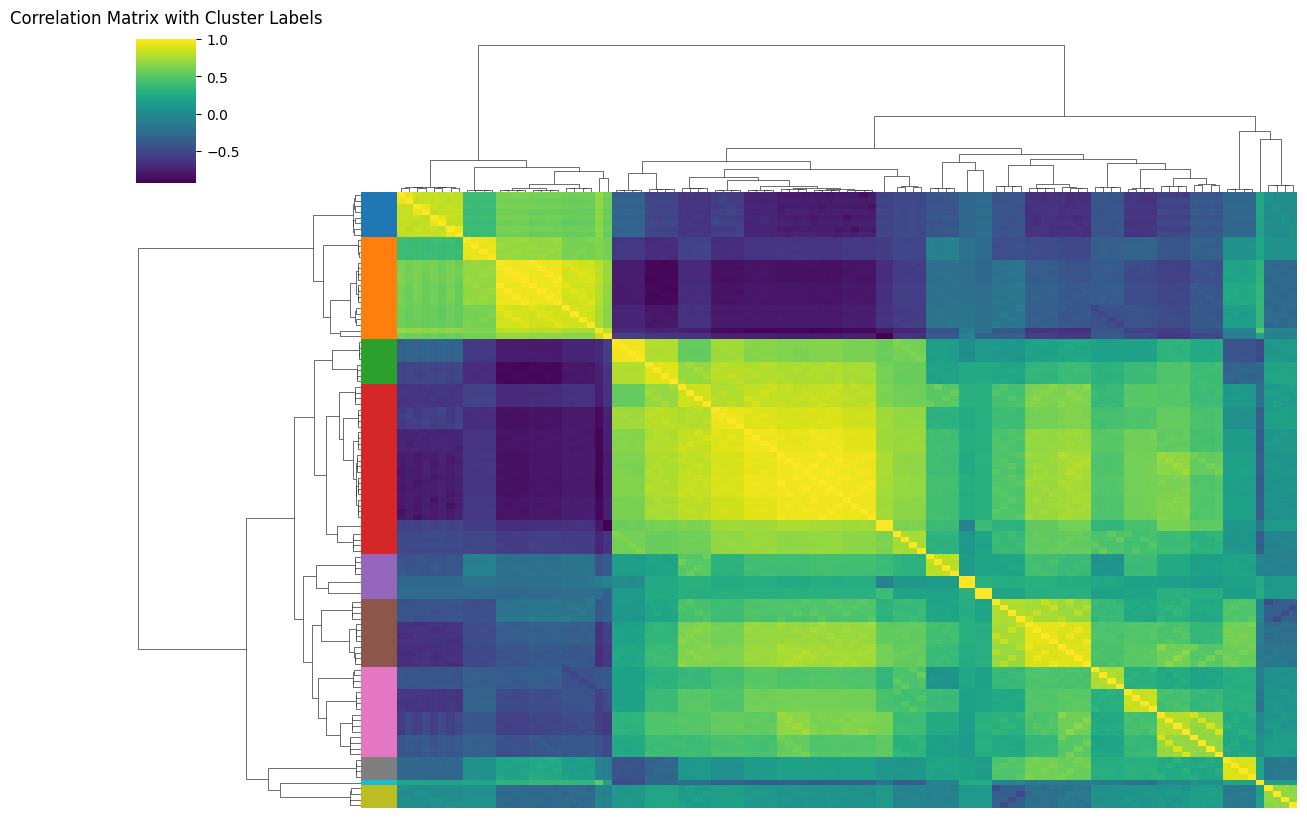

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster

# Compute the correlation matrix
cm = PersistenceDB.corr(method="spearman")

# Create clustered heatmap
g = sns.clustermap(cm, cmap='viridis', figsize=(12, 12),
                   metric='euclidean', method='average',
                   row_cluster=True, col_cluster=True,
                   xticklabels=False, yticklabels=False)

# Optional: rotate x-axis labels for readability
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)

# Get the linkage matrix from the dendrogram (row and column are same in correlation matrix)
linkage_matrix = g.dendrogram_row.linkage

# Choose number of clusters (or use distance threshold)
num_clusters = 10
cluster_labels = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')

# Get reordered feature names (after clustering)
ordered_features = g.dendrogram_row.reordered_ind
feature_names = cm.index[ordered_features]

# Map features to cluster labels
feature_to_cluster = dict(zip(feature_names, cluster_labels))
# Reorder original correlation matrix by clustering
reordered_cm = cm.iloc[ordered_features, ordered_features]

# Create a labeled DataFrame for annotation
reordered_features = cm.index[ordered_features]
cluster_ids = [feature_to_cluster[f] for f in reordered_features]
cluster_df = pd.DataFrame({'Feature': reordered_features, 'Cluster': cluster_ids})


import matplotlib.colors as mcolors

# Assign colors to clusters
unique_clusters = sorted(set(cluster_labels))
palette = sns.color_palette("tab10", len(unique_clusters))
cluster_colors = [palette[c - 1] for c in cluster_ids]  # zero-indexed

# Re-run clustermap with row_colors
g = sns.clustermap(cm, cmap='viridis', figsize=(12, 8),
                   row_cluster=True, col_cluster=True,
                   row_colors=cluster_colors,
                   #col_colors=cluster_colors,
                   xticklabels=False, yticklabels=False)

plt.title("Correlation Matrix with Cluster Labels", y=1.05)
plt.show()


In [ ]:
# Only consider the lower triangle (excluding the diagonal)
mask = np.tril(np.ones(cm.shape), k=-1).astype(bool)
correlations = cm.where(mask).stack()

# Compute summary stats
abs_corr = correlations.abs()
median_abs_corr = abs_corr.median()
iqr = abs_corr.quantile([0.25, 0.75])
strong_corr_pct = (abs_corr > 0.75).mean() * 100
strong_neg_corr_pct = (correlations < -0.75).mean() * 100
strong_pos_corr_pct = (correlations > 0.75).mean() * 100
num_pairs = len(correlations)

# Format for manuscript
print(f"Among {num_pairs:,} unique feature pairs, the median absolute correlation was {median_abs_corr:.2f} "
      f"(IQR: {iqr[0.25]:.2f}–{iqr[0.75]:.2f}). "
      f"{strong_corr_pct:.1f}% of pairs showed strong correlations (|r| > 0.75)."
      f" {strong_neg_corr_pct:.1f}% of pairs showed strong negative correlations (r < -0.75)."
      f" {strong_pos_corr_pct:.1f}% of pairs showed strong positive correlations (r > 0.75).")

Among 5,886 unique feature pairs, the median absolute correlation was 0.48 (IQR: 0.29–0.68). 17.3% of pairs showed strong correlations (|r| > 0.75). 7.3% of pairs showed strong negative correlations (r < -0.75). 10.0% of pairs showed strong positive correlations (r > 0.75).


<Axes: ylabel='Count'>

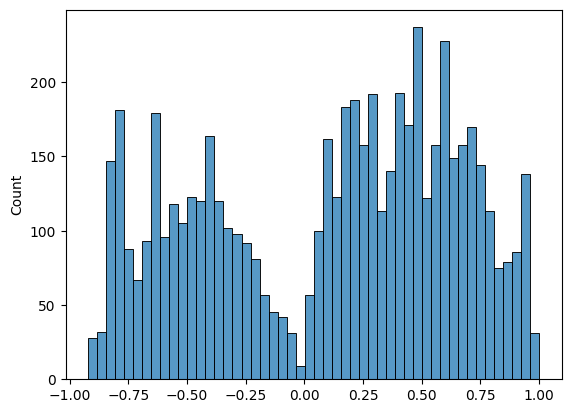

In [ ]:
import seaborn as sns
sns.histplot(cm.values[np.tril_indices_from(cm, k=-1)], bins=50)

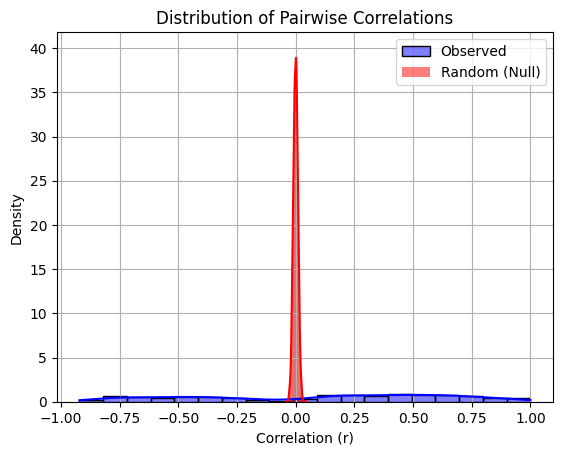

10221


In [ ]:
import numpy as np
import pandas as pd

n_samples = PersistenceDB.shape[0]
n_features = PersistenceDB.shape[1]

# Simulate random data with the same shape
random_df = pd.DataFrame(np.random.randn(n_samples, n_features),
                         columns=[f"rand_{i}" for i in range(n_features)])

null_corr = random_df.corr(method="spearman")

import seaborn as sns
import matplotlib.pyplot as plt

def lower_triangle_vals(mat):
    return mat.values[np.tril_indices_from(mat, k=-1)]

obs_vals = lower_triangle_vals(cm)
null_vals = lower_triangle_vals(null_corr)

sns.histplot(obs_vals, label="Observed", color='blue', stat='density', kde=True)
sns.histplot(null_vals, label="Random (Null)", color='red', stat='density', kde=True, alpha=0.5)
plt.title("Distribution of Pairwise Correlations")
plt.xlabel("Correlation (r)")
plt.legend()
plt.grid()
plt.show()

print(n_samples)


In [62]:
example_activities = label2.classes_
positions = [ index for index, item in enumerate(label2.classes_) if item in example_activities]

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#X_train_combined_persistence = scaler.fit_transform(X_train_combined_persistence)
import pandas as pd


X_combinedscaled = np.nan_to_num(X_combined_persistence, nan=0.0, posinf=0.0, neginf=0.0)
X_combinedscaled = scaler.fit_transform(X_combinedscaled)

mask = np.isin(y, positions)
subset_Xtrain = X_combinedscaled[mask]
subset_ytrain = y[mask]

pca = PCA(n_components=10, svd_solver='full')
principal_components = pca.fit(subset_Xtrain)
print(pca.explained_variance_ratio_)
principal_components = pca.fit_transform(subset_Xtrain)

# Create a DataFrame for the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2','PC3','PC4','PC5','PC6', 'PC7', 'PC8', 'PC9', 'PC10'])
pca_df


[0.51569903 0.11078363 0.05693095 0.03838238 0.02553521 0.01987055
 0.01846882 0.01034041 0.00743855 0.00712094]


PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0      1.718552  6.278296  1.953166  1.539134  1.904039  2.800969 -0.074688   
1      1.497745  6.466531  2.388021  2.126529  2.267918  2.249656  0.213261   
2      2.077193  6.900166  2.255665  2.292935  2.783173  1.702784  0.063173   
3      3.293615  6.835207  2.517388  1.995258  1.889239  1.594662  0.365227   
4      5.273723  6.388705  1.829164  1.992316 -0.204474  1.569265  0.483935   
...         ...       ...       ...       ...       ...       ...       ...   
29950  4.781453 -1.945061  3.796406 -0.898959  2.567694  0.001463 -1.417934   
29951  2.463284 -0.951451  4.038741 -1.234142  1.751874  0.120824 -0.433183   
29952  2.071949 -0.749375  4.154548 -1.654077  0.919857  0.876315  0.082559   
29953  4.203724 -0.924779  3.745450 -1.189236  1.173454 -0.142449 -1.088833   
29954  5.022754 -0.620159  3.520168 -1.718512  1.991338 -1.672012 -1.678853   

            PC8       PC9      PC10  
0      0.924360 -0.061372 -0.500424  
1      0.083492  0.217387  0.171266  
2     -0.525191 -0.637487 -0.036254  
3     -0.357591  0.940031  0.516246  
4      0.202928  0.366356 -0.791349  
...         ...       ...       ...  
29950  0.083557 -0.334895  0.654019  
29951  0.546880 -0.567426 -0.419047  
29952  0.292337 -0.241204  0.004984  
29953 -0.222047  0.932493  0.276641  
29954  0.490494 -0.255882 -0.604136  

[29955 rows x 10 columns]

## Subset Users

/tmp/ipython-input-580077711.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_categories)) # Choose a colormap


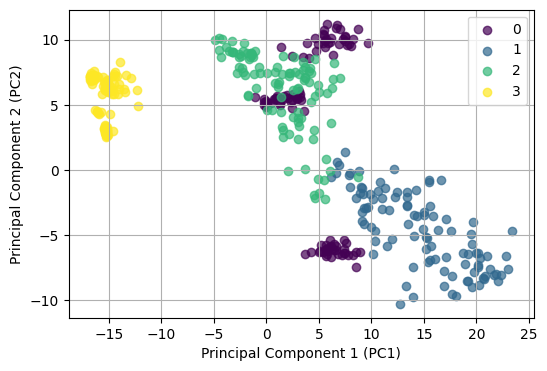

In [64]:
unique_users = np.unique(users)[0:3]
#unique_users = ['1','3','5']


plt.figure(figsize=(6, 4))

# Get unique categories and assign a color to each
unique_categories = np.unique(y)[0:4]
colors = plt.cm.get_cmap('viridis', len(unique_categories)) # Choose a colormap
mask = np.isin(users,unique_users)

pc1 = '1'
pc2 = '2'


if WISDM6:
  label_dict = {0:'',
              1:'Jogging',
              2:'Sitting',
              3:'Standing',
              4:'Upstairs',
              5:'Walking'}

for i, category in enumerate(unique_categories):
    subset = pca_df[(y == category) & mask]
    plt.scatter(subset[f'PC{pc1}'], subset[f'PC{pc2}'],
                label=str(category),
                color=colors(i),
                alpha=0.7)

plt.xlabel(f'Principal Component {pc1} (PC{pc1})')
plt.ylabel(f'Principal Component {pc2} (PC{pc2})')
#plt.title('PCA Plot with Discrete Colors')
plt.legend()
plt.grid(True)
plt.show()

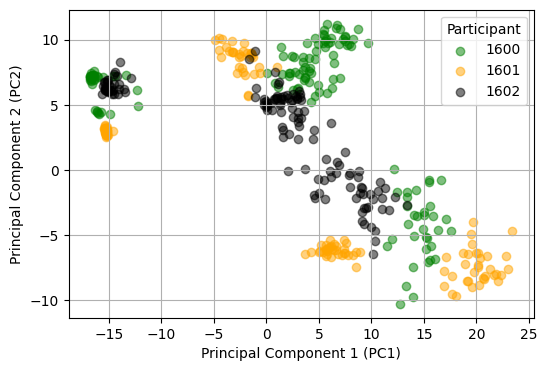

In [65]:
unique_users = np.unique(users)[0:3]
#unique_users = ['3','4','5','6']
mask2 = np.isin(y,unique_categories)


plt.figure(figsize=(6, 4))

# Get unique categories and assign a color to each
unique_categories = np.unique(subset_ytrain)[0:4]
colors = ['green','orange','black','magenta'] # Choose a colormap

pc1 = '1'
pc2 = '2'
for i, user in enumerate(unique_users):
    mask = np.isin(users,user)
    subset = pca_df[mask & mask2]
    plt.scatter(subset[f'PC{pc1}'], subset[f'PC{pc2}'],
                label=user,
                color=colors[i],
                alpha=0.5)

plt.xlabel(f'Principal Component {pc1} (PC{pc1})')
plt.ylabel(f'Principal Component {pc2} (PC{pc2})')

#plt.title('PCA Plot with Discrete Colors')
plt.legend(title='Participant')
plt.grid(True)
plt.show()



# All Activities PCA

In [79]:
# 1. Build the group mapping based on label.classes_
non_hand = [
    "A", "B", "C", "D", "E", "M"
]
hand_general = [
    "F", "G", "O", "P", "Q", "R", "S"
]
hand_eating = [
    'H','I','J','K','L'
]

label_names = label2.classes_  # List of 18 activity names in the correct order
label_to_group = {}

if WISDM18:
  # 2. Map each label index to a group name
  for idx, activity in enumerate(label_names):
    if activity in non_hand:
        label_to_group[idx] = "1-Non-hand-oriented"
    elif activity in hand_general:
        label_to_group[idx] = "2-Hand-oriented (general)"
    elif activity in hand_eating:
        label_to_group[idx] = "3-Hand-oriented (eating)"
    else:
        label_to_group[idx] = "Unknown"

  # 3. Create group labels for your y_train
  group_labels = np.array([label_to_group[label] for label in y])


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#X_train_combined_persistence_accel = np.nan_to_num(X_train_combined_persistence_accel)
#X_train_combined_persistence_accel_scaled = scaler.fit_transform(X_train_combined_persistence_accel)
import pandas as pd

XPC = scaler.fit_transform(X_combined_persistence)

pca = PCA(n_components=15, svd_solver='full')
principal_components = pca.fit_transform(XPC)
print(pca.explained_variance_ratio_)
#principal_components_accel = pca.fit_transform(X_train_combined_persistence_accel_scaled)

# Create a DataFrame for the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2','PC3','PC4',
                                                          'PC5','PC6','PC7','PC8',
                                                          'PC9','PC10','PC11','PC12',
                                                          'PC13', 'PC14','PC15'])
pca_df







[0.50394476 0.1144038  0.07430398 0.03356803 0.02959503 0.02543802
 0.02131205 0.02032956 0.01508179 0.01031827 0.00923526 0.00916569
 0.00915363 0.00911656 0.00829334]


PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0       2.702220  0.798947 -0.317949 -0.894655  1.311246 -1.988384 -1.849587   
1       3.667383  2.208222 -0.288367 -1.078437  2.331777 -2.727396 -1.688642   
2       3.930121  2.245126 -0.427088 -0.362800  1.429171 -1.564151 -1.200901   
3       3.755104  1.454767 -0.400422  0.854924  1.179175  0.164513 -1.217102   
4      -0.223025  0.442195  1.127784 -1.704371  4.068228 -1.594065 -1.886889   
...          ...       ...       ...       ...       ...       ...       ...   
10216 -16.102353  0.509543 -0.801331  2.133186 -1.316208 -3.120794  1.191417   
10217 -15.925668 -0.026656 -0.730421  2.601286 -1.621787 -2.897889  1.841626   
10218 -15.638210  0.980111 -0.754294  0.934025 -0.928348 -1.451390 -0.081389   
10219 -15.715750  0.382673 -1.059459  1.611760 -1.509715 -1.780945 -0.383048   
10220 -16.231909  0.043383 -1.012160  3.509423 -1.881005 -3.117178  0.653430   

            PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0      1.417640  1.515919  0.808931  0.124415 -0.166742  0.013614 -0.093377   
1      1.702632  1.439333  0.042195  0.147308 -0.249453 -0.021407  0.057980   
2      1.400605  0.995735  0.749386 -1.785076 -3.394179 -0.471775 -0.471284   
3      1.033825  1.168921  1.030764  0.312725 -0.303574  0.005893 -0.089190   
4      1.283525 -0.721002 -1.324752  0.186642 -0.168418 -0.103630  0.188293   
...         ...       ...       ...       ...       ...       ...       ...   
10216  0.762566 -0.957887  1.414897  0.134619  0.056066  0.080119 -0.146684   
10217  0.445889 -0.979905  1.127767  0.148393  0.082432  0.038000 -0.104841   
10218  0.716637  0.339282  0.123913  0.155192  0.003735  0.048595  0.040718   
10219  0.685399  0.879645  0.548555  0.148876 -0.064469  0.085255 -0.025876   
10220  0.629376  0.226514  1.161827  0.170601  0.002454  0.065623 -0.094633   

           PC15  
0      0.040100  
1      0.312485  
2      0.372449  
3      0.218960  
4      0.594959  
...         ...  
10216 -0.299376  
10217 -0.243245  
10218  0.257906  
10219  0.065433  
10220 -0.271055  

[10221 rows x 15 columns]

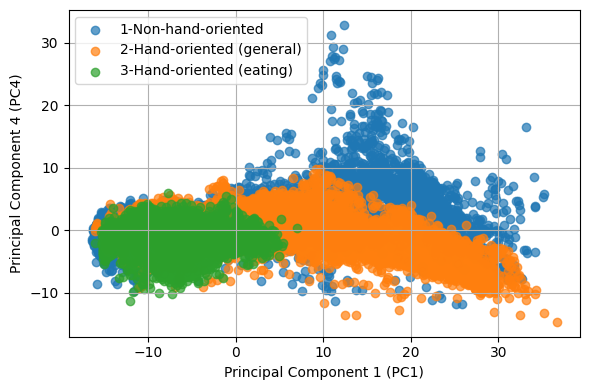

In [85]:

# Get unique categories and assign a color to each
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))

if WISDM18:
  group_names = np.unique(group_labels)
  group_colors = {
      "1-Non-hand-oriented": "tab:blue",
      "2-Hand-oriented (general)": "tab:orange",
      "3-Hand-oriented (eating)": "tab:green"
  }


  for group in group_names:
      subset = pca_df[group_labels == group]
      plt.scatter(subset['PC1'], subset['PC4'],
                  label=group,
                  color=group_colors[group],
                  alpha=0.7)

  plt.xlabel('Principal Component 1 (PC1)')
  plt.ylabel('Principal Component 4 (PC4)')
  #plt.title('PCA: 3 Activity Groups')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

In [ ]:
from tensorflow.keras import backend as K
K.clear_session()

## Hyperparameter Tuning

In [ ]:
from keras_tuner.tuners import RandomSearch
y_oneshot = to_categorical(y, num_classes=len(label.classes_))

tuner = RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=20,
    executions_per_trial=1,
    directory="tuner_dir",
    project_name="tda_timeseries"
)

tuner.search(
    [X, X_combined_persistence],  # input
    y_oneshot,                # output
    validation_split=0.2,
    epochs=10,
    callbacks=[early_stopping],
    verbose=2
)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

## Not running correctly, labels not matched to input

In [68]:
!pip install keras_tuner
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, RepeatVector, Lambda, Concatenate, LSTM, Conv1D,
    Dropout, AvgPool1D, BatchNormalization, Bidirectional, Flatten
)
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2, L1L2
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.utils import class_weight
from tqdm import tqdm
import keras_tuner as kt

# ----- GPU Setup -----
gpus = tf.config.list_physical_devices('GPU')
print("GPUs available:", gpus)

# Enable mixed precision
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.3 MB/s eta 0:00:00
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [69]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, RepeatVector, Lambda, Concatenate, LSTM, Conv1D,
    Dropout, AvgPool1D, BatchNormalization, Bidirectional, Flatten
)
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2, L1L2
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.utils import class_weight
from tqdm import tqdm
import keras_tuner as kt

# ----- GPU Setup -----
gpus = tf.config.list_physical_devices('GPU')
print("GPUs available:", gpus)

# Enable mixed precision
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# ----- Inputs -----
n_splits = 5
cv_results = []
fold_histories = []
all_val_preds = []
all_val_true = []

# ----- Learning rate scheduler -----
def cosine_annealing(epoch, lr):
    max_lr = 1e-3
    min_lr = 1e-4
    epoch_cycle = 20
    return min_lr + 0.5 * (max_lr - min_lr) * (1 + np.cos(np.pi * epoch / epoch_cycle))
lr_callback = LearningRateScheduler(cosine_annealing)

# ----- Subset for tuner (speed up) -----
subset_frac = 0.5  # use 20% of data for tuning
subset_idx = np.random.choice(len(y), int(len(y)*subset_frac), replace=False)
X_subset = X[subset_idx]
X_combined_persistence_subset = X_combined_persistence[subset_idx]
y_subset = y[subset_idx]
users_subset = np.array(users)[subset_idx]

# ----- Compute class weights on subset -----
cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_subset), y=y_subset)
class_weights_dict = {i: w for i, w in enumerate(cw)}

# ----- Build model function for Keras Tuner -----
def build_tuned_model(hp, input_shape_time_series, input_shape_tda, num_classes, tda_include=True):
    lstm_units_1 = hp.Int('lstm_units_1', 16, 16, step=8)
    lstm_units_2 = hp.Int('lstm_units_2', 8, 16, step=4)
    conv_filters_1 = hp.Int('conv_filters_1', 16, 32, step=8)
    conv_filters_2 = hp.Int('conv_filters_2',8, 16, step=8)
    dense_units = hp.Int('dense_units', 16, 32, step=8)
    dropout_rate = hp.Float('dropout_rate', 0.2, 0.5, step=0.1)
    kernel_l2 = hp.Choice('kernel_l2', [0.001, 0.01, 0.1])
    l1 = hp.Choice('l1', [0.001, 0.01])
    l2 = hp.Choice('l2', [0.001, 0.01])
    learning_rate = hp.Choice('learning_rate', [5e-4, 1e-4])

    tda_input = Input(shape=input_shape_tda, name='tda_input')
    ts_input = Input(shape=input_shape_time_series, name='time_series_input')

    x = AvgPool1D(pool_size=3)(ts_input)
    x = Conv1D(conv_filters_1, kernel_size=3, padding='same', activation='relu', kernel_regularizer=L2(kernel_l2))(x)
    x = Bidirectional(LSTM(lstm_units_1, return_sequences=True))(x)
    x = BatchNormalization()(x)
    x = LSTM(lstm_units_2, return_sequences=True)(x)
    x = Dropout(dropout_rate)(x)
    x = Conv1D(conv_filters_2, kernel_size=3, padding='same', activation='relu', kernel_regularizer=L2(kernel_l2))(x)
    x = AvgPool1D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)

    if tda_include:
        tda_branch = BatchNormalization()(tda_input)
        tda_branch = Dense(conv_filters_2, activation='relu', kernel_regularizer=L1L2(l1=l1, l2=l2))(tda_branch)
        x = Concatenate()([x, tda_branch])

    x = Dense(dense_units, activation='relu', kernel_regularizer=L2(kernel_l2))(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(num_classes, activation='softmax', kernel_regularizer=L2(kernel_l2))(x)

    model = Model(inputs=[ts_input, tda_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# ----- Compute total trials for progress bar -----
def estimate_total_trials(max_epochs, factor):
    # Hyperband formula approximate: (log_factor(max_epochs) * factor)
    import math
    s_max = int(math.log(max_epochs) / math.log(factor))
    total = sum([(s_max + 1 - i) * factor**i for i in range(s_max+1)])
    return total

max_epochs = 20
factor = 3
total_trials_estimate = estimate_total_trials(max_epochs, factor)
progress_bar = tqdm(total=total_trials_estimate, desc="Hyperparameter Tuning Progress")

# ----- Custom Hyperband Tuner -----
class TunerWithProgress(kt.Hyperband):
    def run_trial(self, trial, *args, **kwargs):
        result = super().run_trial(trial, *args, **kwargs)
        self._progress_bar.update(1)
        return result

tuner = TunerWithProgress(
    hypermodel=lambda hp: build_tuned_model(hp, X_subset.shape[1:], X_combined_persistence_subset.shape[1:], num_classes=len(np.unique(y))),
    objective='accuracy',
    max_epochs=max_epochs,
    factor=factor,
    directory='tuner_dir',
    project_name='time_series_tda'
)
tuner._progress_bar = progress_bar

# Early stopping + LR scheduler
early_stopping = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)

# ----- Run tuner on subset -----
tuner.search(
    x=[X_subset, X_combined_persistence_subset],
    y=tf.keras.utils.to_categorical(y_subset),
    batch_size=512,
    epochs=max_epochs,
    callbacks=[early_stopping, lr_callback],
    class_weight=class_weights_dict,
    verbose=0
)
progress_bar.close()

best_hp = tuner.get_best_hyperparameters()[0]
print("Best Hyperparameters:", best_hp.values)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)


# ----- Full CV with best hyperparameters -----
gkf = GroupKFold(n_splits=n_splits)
num_classes = len(np.unique(y))

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups=users)):
    print(f"\n==== Fold {fold+1} ====")
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]
    X_train_fold_persistence = X_combined_persistence[train_idx]
    X_val_fold_persistence = X_combined_persistence[val_idx]

    y_train_fold_onehot = tf.keras.utils.to_categorical(y_train_fold, num_classes=num_classes)
    y_val_fold_onehot = tf.keras.utils.to_categorical(y_val_fold, num_classes=num_classes)

    cw_fold = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_fold), y=y_train_fold)
    class_weights_dict_fold = {i: w for i, w in enumerate(cw_fold)}

    model_fold = build_tuned_model(bestest_hp, X_train_fold.shape[1:], X_train_fold_persistence.shape[1:], num_classes)

    early_stopping_cv = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)

    batch_size = 512
    train_dataset = tf.data.Dataset.from_tensor_slices(((X_train_fold, X_train_fold_persistence), y_train_fold_onehot)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_dataset = tf.data.Dataset.from_tensor_slices(((X_val_fold, X_val_fold_persistence), y_val_fold_onehot)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    history = model_fold.fit(train_dataset,
                             validation_data=val_dataset,
                             epochs=200,
                             callbacks=[early_stopping_cv, lr_callback],
                             class_weight=class_weights_dict_fold)

    fold_histories.append(history.history)

    best_epoch = np.argmax(history.history['val_accuracy'])
    y_val_pred = model_fold.predict(val_dataset)
    y_val_class = np.argmax(y_val_pred, axis=1)

    all_val_preds.extend(y_val_class)
    all_val_true.extend(y_val_fold)

    acc = accuracy_score(y_val_fold, y_val_class)
    prec = precision_score(y_val_fold, y_val_class, average='macro', zero_division=0)
    rec = recall_score(y_val_fold, y_val_class, average='macro', zero_division=0)
    f1 = f1_score(y_val_fold, y_val_class, average='macro', zero_division=0)

    cv_results.append({
        'fold': fold+1,
        'train_accuracy': history.history['accuracy'][best_epoch],
        'val_accuracy': history.history['val_accuracy'][best_epoch],
        'train_loss': history.history['loss'][best_epoch],
        'val_loss': history.history['val_loss'][best_epoch],
        'best_epoch': best_epoch,
        'precision': prec,
        'recall': rec,
        'f1_score': f1
    })

# ----- CV Summary -----
df_results = pd.DataFrame(cv_results)
print("\n=== Cross-Validation Summary ===")
print(df_results.round(4))
print("\nAverage Val Accuracy: {:.4f} ± {:.4f}".format(df_results['val_accuracy'].mean(), df_results['val_accuracy'].std()))

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
for i, hist in enumerate(fold_histories):
    plt.plot(hist['val_accuracy'], label=f'Fold {i+1}')
plt.title("Validation Accuracy per Fold")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n=== Combined Classification Report ===")
from sklearn.metrics import classification_report
print(classification_report(all_val_true, all_val_preds, zero_division=0, digits=3))


GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Hyperparameter Tuning Progress:   0%|          | 0/18 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
model_fold.()

Model: "functional_46"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ time_series_input   │ (None, 200, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_… │ (None, 66, 4)     │          0 │ time_series_inpu… │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_92 (Conv1D)  │ (None, 66, 16)    │        208 │ average_pooling1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_46    │ (None, 66, 32)    │      4,224 │ conv1d_92[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 66, 32)    │        128 │ bidirectional_46… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_93 (LSTM)      │ (None, 66, 8)     │      1,312 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_92          │ (None, 66, 8)     │          0 │ lstm_93[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_93 (Conv1D)  │ (None, 66, 32)    │        800 │ dropout_92[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_… │ (None, 33, 32)    │          0 │ conv1d_93[0][0]   │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tda_input           │ (None, 230)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 32)    │        128 │ average_pooling1… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 230)       │        920 │ tda_input[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_46          │ (None, 1056)      │          0 │ batch_normalizat… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_138 (Dense)   │ (None, 32)        │      7,392 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_46      │ (None, 1088)      │          0 │ flatten_46[0][0], │
│ (Concatenate)       │                   │            │ dense_138[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_139 (Dense)   │ (None, 8)         │      8,712 │ concatenate_46[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_93          │ (None, 8)         │          0 │ dense_139[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_140 (Dense)   │ (None, 6)         │         54 │ dropout_93[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 70,464 (275.26 KB)

 Trainable params: 23,290 (90.98 KB)

 Non-trainable params: 588 (2.30 KB)

 Optimizer params: 46,586 (181.99 KB)

In [ ]:
np.save("X.npy", X)
np.save('y.npy', y)
np.save('users.npy', users)
np.save('X_combined_persistence.npy', X_combined_persistence)


# Load pre-processed feature files (manual upload)

In [3]:
X = np.load("X.npy")
y = np.load('y.npy')
users = np.load('users.npy')
X_combined_persistence = np.load('X_tda.npy')


In [ ]:
!pip install keras-tuner

import tensorflow as tf

print("GPU Available:", tf.config.list_physical_devices('GPU'))
!nvidia-smi

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Sun Aug 24 02:20:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             50W /  400W |    6905MiB /  40960MiB |      0%      Default |
|                                         |               

## Add augmentation (optional)

In [1]:
import numpy as np

def add_gaussian_noise(X, noise_factor=0.01):
    """
    Adds Gaussian noise to the data.
    """
    noise = np.random.normal(0, noise_factor, X.shape)
    return X + noise

def random_scaling(X, scale_factor_range=(0.9, 1.1)):
    """
    Randomly scales the data.
    """
    scale_factor = np.random.uniform(low=scale_factor_range[0], high=scale_factor_range[1], size=(X.shape[0], 1, 1))
    return X * scale_factor

def time_shift(X, shift_range=(-10, 10)):
    """
    Randomly shifts the data along the time axis.
    """
    augmented_X = np.zeros_like(X)
    for i in range(X.shape[0]):
        shift = np.random.randint(shift_range[0], shift_range[1])
        augmented_X[i, :, :] = np.roll(X[i, :, :], shift, axis=0)
    return augmented_X

def flip_channels(X):
    """
    Randomly flips the signs of the first three channels.
    """
    flip_signs = np.random.choice([-1, 1], size=(X.shape[0], 1, X.shape[2]))
    return X * flip_signs



def augment_data_and_recalculate_magnitude(X, n_augmentations=1):
    """
    Generates augmented samples by applying transformations to the first 3 channels
    and recalculating the 4th (magnitude) channel.

    Args:
        X (np.ndarray): Original data with shape (N, L, 4).
        n_augmentations (int): Number of augmented samples to generate per original sample.

    Returns:
        np.ndarray: Augmented data with shape (N * n_augmentations, L, 4).
    """

    # 1. Separate the first 3 channels from the 4th (magnitude) channel
    X_channels_1_3 = X[:, :, :3]

    augmented_samples = []

    for _ in range(n_augmentations):
        # 2. Apply a combination of augmentation techniques
        # You can choose which augmentations to apply
        augmented_channels_1_3 = add_gaussian_noise(X_channels_1_3)
        #augmented_channels_1_3 = random_scaling(augmented_channels_1_3)
        #augmented_channels_1_3 = time_shift(augmented_channels_1_3)

        # 3. Recalculate the magnitude (4th channel)
        # Use np.linalg.norm for a vectorized calculation
        new_magnitude_channel = np.linalg.norm(augmented_channels_1_3, axis=2, keepdims=True)

        # 4. Concatenate the augmented channels with the new magnitude channel
        augmented_full_array = np.concatenate(
            [augmented_channels_1_3, new_magnitude_channel], axis=2
        )

        augmented_samples.append(augmented_full_array)

    # 5. Concatenate all augmented samples together
    return np.concatenate(augmented_samples, axis=0)



# Final Model

In [61]:
from sklearn.preprocessing import LabelEncoder
label2 = LabelEncoder()
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
    Input, Dense, RepeatVector, Lambda, Concatenate, LSTM, Conv1D,
    Dropout, AvgPool1D, BatchNormalization, Bidirectional, Flatten, MaxPool1D
)
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2, L1L2

scaler = StandardScaler()

X_combinedscaled = np.nan_to_num(X_combined_persistence, nan=0.0, posinf=0.0, neginf=0.0)
X_combinedscaled = scaler.fit_transform(X_combinedscaled)

y2 = label2.fit_transform(y)
final_model = True
tda_include = True
current_version = True

#gkf = GroupKFold(n_splits=n_splits)
cv_results = []
all_val_preds = []
all_val_true = []
fold_histories = []
best_hps_per_fold = []

num_classes=18

#input_shape_tda = X_combined_persistence[0].shape
#input_shape_time_series = X_train[0].shape
if final_model:
    lstm_units_1 = 8
    lstm_units_2 = 8
    conv_filters_1 = 8
    conv_filters_2 = 16
    dense_units = 32
    dropout_rate = 0.3
    kernel_l2 = 0.001
    l1 = 0.001
    l2 = 0.001
    learning_rate = 1e-3

    # --- Inputs ---
    tda_input = Input(shape=X_combinedscaled[0].shape, name='tda_input')
    ts_input = Input(shape=X[0].shape, name='time_series_input')
    x = AvgPool1D(pool_size=2)(ts_input)

    if (tda_include==True and current_version==False):
        tda_branch = BatchNormalization()(tda_input)
        tda_branch = Dropout(dropout_rate)(tda_input)
        tda_branch = Dense(4, activation='relu', kernel_regularizer=L1L2(l1=l1, l2=l2))(tda_branch)
        x2 = RepeatVector(x.shape[1])(tda_branch)
        x = Concatenate()([x, x2])
    # --- Time Series branch ---
    x = BatchNormalization()(x)
    x = Conv1D(conv_filters_1, kernel_size=3, padding='same', activation='relu',
               kernel_regularizer=tf.keras.regularizers.L2(kernel_l2))(x)
    x = Bidirectional(LSTM(lstm_units_1, return_sequences=True))(x)
    #x = BatchNormalization()(x)
    x = LSTM(lstm_units_2, return_sequences=True)(x)
    x = Dropout(dropout_rate)(x)
    x = Conv1D(conv_filters_2, kernel_size=3, padding='same', activation='relu',
               kernel_regularizer=tf.keras.regularizers.L2(kernel_l2))(x)
    x = MaxPool1D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)

    # --- TDA branch ---
    if (tda_include==True and current_version==True):
        tda_branch = BatchNormalization()(tda_input)
        x = Dropout(dropout_rate)(x)
        tda_branch = Dense(conv_filters_2, activation='relu',
                           kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1, l2=l2))(tda_branch)
        x = Concatenate()([x, tda_branch])

    # --- Output ---
    #x = Dropout(dropout_rate)(x)
    x = Dense(dense_units, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(kernel_l2))(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.L2(kernel_l2), dtype='float32')(x)

    combined_model = Model(inputs=[ts_input, tda_input], outputs=output)
    combined_model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy', metrics=['accuracy'])


print(tda_include)
combined_model.summary()


True


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ time_series_input   │ (None, 200, 8)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_… │ (None, 100, 8)    │          0 │ time_series_inpu… │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 8)    │         32 │ average_pooling1… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 100, 8)    │        200 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_16    │ (None, 100, 16)   │      1,088 │ conv1d_32[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_33 (LSTM)      │ (None, 100, 8)    │        800 │ bidirectional_16… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_49          │ (None, 100, 8)    │          0 │ lstm_33[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 100, 16)   │        400 │ dropout_49[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 50, 16)    │          0 │ conv1d_33[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 16)    │         64 │ max_pooling1d[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tda_input           │ (None, 508)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_16          │ (None, 800)       │          0 │ batch_normalizat… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 508)       │      2,032 │ tda_input[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_50          │ (None, 800)       │          0 │ flatten_16[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_48 (Dense)    │ (None, 16)        │      8,144 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_22      │ (None, 816)       │          0 │ dropout_50[0][0], │
│ (Concatenate)       │                   │            │ dense_48[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_49 (Dense)    │ (None, 32)        │     26,144 │ concatenate_22[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_51          │ (None, 32)        │          0 │ dense_49[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 39,498 (154.29 KB)

 Trainable params: 38,434 (150.13 KB)

 Non-trainable params: 1,064 (4.16 KB)

In [86]:
type(X_combinedscaled)
pca = PCA(n_components=5, svd_solver='full')
pc_tda = pca.fit_transform(X_combinedscaled)
pc_tda.shape

(29955, 5)

Precision policy: <DTypePolicy "mixed_float16">


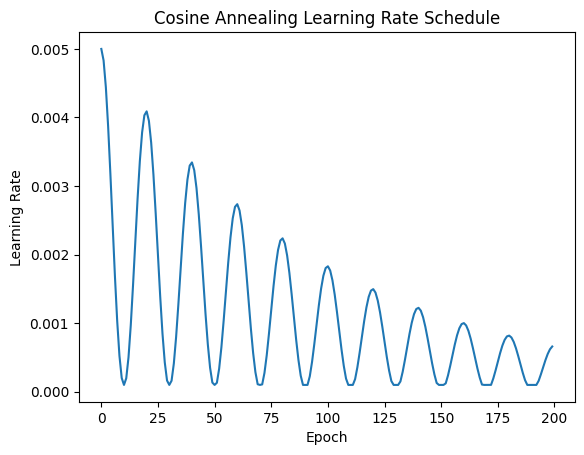

29955

==== Fold 1 ====
(23599, 200, 8)
23599
(23599, 200, 8)
(23599, 508)
Train users: ['1600' '1601' '1603' '1604' '1607' '1608' '1609' '1610' '1611' '1612'
 '1613' '1614' '1615' '1617' '1618' '1619' '1620' '1621' '1622' '1624'
 '1625' '1626' '1627' '1629' '1631' '1632' '1633' '1634' '1636' '1637'
 '1638' '1640' '1641' '1642' '1644' '1645' '1646' '1647' '1649' '1650']
Val users:   ['1602' '1605' '1606' '1616' '1623' '1628' '1630' '1635' '1639' '1643'
 '1648']
(23599, 200, 8)
(6356, 200, 8)
Epoch 1/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.1489 - loss: 3.1294 - val_accuracy: 0.1902 - val_loss: 2.6993 - learning_rate: 0.0050
Epoch 2/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.2883 - loss: 2.2862 - val_accuracy: 0.2645 - val_loss: 2.5907 - learning_rate: 0.0048
Epoch 3/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3433 - loss: 2.0378 - val_accuracy: 0.3980 - val_loss: 2.4298 - learning_rate: 0.0044
Epoch 4/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/

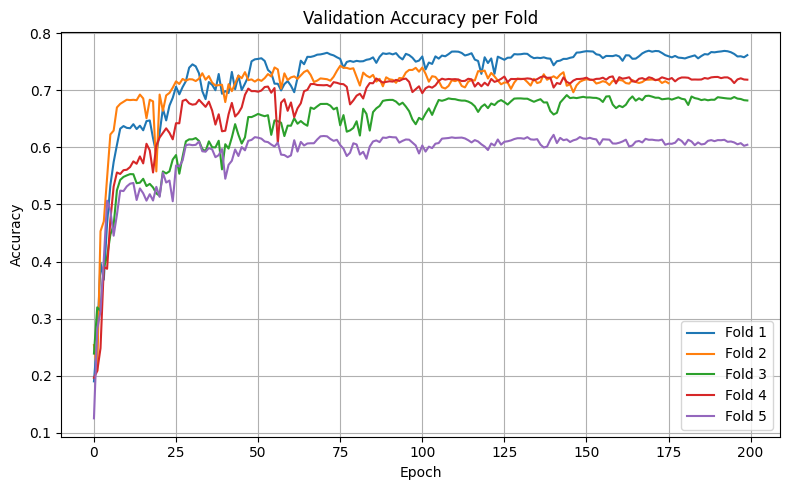


=== Combined Validation Classification Report ===
              precision    recall  f1-score   support

           0      0.782     0.718     0.748      1655
           1      0.995     0.944     0.969      1612
           2      0.714     0.608     0.657      1630
           3      0.618     0.620     0.619      1719
           4      0.654     0.726     0.689      1747
           5      0.799     0.747     0.772      1568
           6      0.825     0.831     0.828      1651
           7      0.631     0.617     0.624      1646
           8      0.555     0.492     0.521      1653
           9      0.582     0.695     0.633      1678
          10      0.566     0.656     0.608      1739
          11      0.246     0.169     0.201      1653
          12      0.712     0.823     0.763      1647
          13      0.861     0.891     0.876      1637
          14      0.920     0.813     0.863      1677
          15      0.775     0.802     0.788      1720
          16      0.898     0.

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import clone_model
from tensorflow.keras.utils import to_categorical # Import to_categorical
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow as tf

from tensorflow.keras.callbacks import LearningRateScheduler


from sklearn.model_selection import GroupKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import clone_model
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight

# ----- Mixed Precision (optional, TPUs work best with bfloat16) -----
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")
print("Precision policy:", mixed_precision.global_policy())



# ----- Learning rate scheduler -----
def cosine_annealing(epoch, lr):
    max_lr = 5e-3
    min_lr = 1e-4
    epoch_cycle = 10
    lr_ret =  (min_lr + 0.5 * (max_lr - min_lr) * (1 + np.cos(np.pi * epoch / epoch_cycle)))*0.99**epoch
    if lr_ret < min_lr:
        lr_ret = min_lr
    if lr_ret > max_lr:
        lr_ret = max_lr
    return lr_ret

lr_callback = LearningRateScheduler(cosine_annealing)

plt.plot([cosine_annealing(i, 0) for i in range(200)])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Cosine Annealing Learning Rate Schedule" )
plt.show()
# ----- Inputs -----
n_splits = 5
cv_results = []
fold_histories = []
all_val_preds = []
all_val_true = []
tda_random = True
augment = False
time_random = False

# GroupKFold to keep user identities separated across folds
gkf = GroupKFold(n_splits=n_splits, shuffle=True, random_state=321)

users = np.array(users)  # Make sure it's a NumPy array if not already
print(len(users))

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups=users)):
    print(f"\n==== Fold {fold+1} ====")

    # Train/Val split
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]

    print(X_train_fold.shape)


    # Example usage with your data shape
    # Assuming X has shape (10221, 200, 4)
    if augment:
      augmented_Xtrain = augment_data_and_recalculate_magnitude(X_train_fold, n_augmentations=1)
      # print(augmented_X.shape)
      # Expected output: (10221, 200, 4)
      X_train_fold = np.concatenate((X_train_fold, augmented_Xtrain), axis=0)
      y_train_fold = np.concatenate((y_train_fold, y_train_fold), axis=0)


    X_train_fold_persistence = X_combinedscaled[train_idx]
    X_val_fold_persistence = X_combinedscaled[val_idx]
    print(len(train_idx))
    print(X_train_fold.shape)
    print(X_train_fold_persistence.shape)

    if tda_random:
        X_train_fold_persistence = np.random.randn(X_train_fold.shape[0], X_train_fold_persistence.shape[1])

    if time_random:
        X_train_fold = np.random.randn(X_train_fold.shape[0], X_train_fold.shape[1], X_train_fold.shape[2])
    # Convert labels to one-hot encoding
    y_train_fold_onehot = to_categorical(y_train_fold, num_classes=num_classes)
    y_val_fold_onehot = to_categorical(y_val_fold, num_classes=num_classes)

    # Reshape if needed
    #X_train_fold = X_train_fold.reshape(X_train_fold.shape[0], X_train_fold.shape[1], X_train_fold.shape[2], 1)
    #X_val_fold = X_val_fold.reshape(X_val_fold.shape[0], X_val_fold.shape[1], X_val_fold.shape[2], 1)


    # Optional: split users
    train_users = np.unique(users[train_idx])
    val_users = np.unique(users[val_idx])
    print(f"Train users: {train_users}")
    print(f"Val users:   {val_users}")

    cw_fold = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_fold), y=y_train_fold)
    class_weights_dict_fold = {i: w for i, w in enumerate(cw_fold)}

    #model_fold = build_tuned_model(bestest_hp, X_train_fold.shape[1:], X_train_fold_persistence.shape[1:], num_classes)

    early_stopping_cv = EarlyStopping(monitor='val_accuracy', patience=100, restore_best_weights=True)

    batch_size = 512
    train_dataset = tf.data.Dataset.from_tensor_slices(((X_train_fold, X_train_fold_persistence), y_train_fold_onehot)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_dataset = tf.data.Dataset.from_tensor_slices(((X_val_fold, X_val_fold_persistence), y_val_fold_onehot)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Clone and compile a fresh model each fold
    model_fold = clone_model(combined_model)
    model_fold.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

    print(X_train_fold.shape)
    print(X_val_fold.shape)
    # Train model
    history = model_fold.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=200,
        batch_size=batch_size,
        callbacks=[early_stopping_cv, lr_callback],
        verbose=1,
        class_weight=class_weights_dict_fold
    )

    fold_histories.append(history.history)

    # Best epoch
    best_epoch = np.argmax(history.history['val_accuracy'])

    # Record metrics
    result = {
        'fold': fold + 1,
        'train_accuracy': history.history['accuracy'][best_epoch],
        'val_accuracy': history.history['val_accuracy'][best_epoch],
        'train_loss': history.history['loss'][best_epoch],
        'val_loss': history.history['val_loss'][best_epoch],
        'best_epoch': best_epoch
    }


    # Store predictions for global eval
    y_val_pred = model_fold.predict([X_val_fold, X_val_fold_persistence])
    y_val_class = np.argmax(y_val_pred, axis=1)
    y_val_true_class = y_val_fold # Use original sparse labels for confusion matrix

    all_val_preds.extend(y_val_class)
    all_val_true.extend(y_val_true_class)

        # Compute per-fold metrics
    acc = accuracy_score(y_val_true_class, y_val_class)
    prec = precision_score(y_val_true_class, y_val_class, average='macro', zero_division=0)
    rec = recall_score(y_val_true_class, y_val_class, average='macro', zero_division=0)
    f1 = f1_score(y_val_true_class, y_val_class, average='macro', zero_division=0)

    # Print
    print(f"Fold {fold+1} accuracy:  {acc:.4f}")
    print(f"Fold {fold+1} precision: {prec:.4f}")
    print(f"Fold {fold+1} recall:    {rec:.4f}")
    print(f"Fold {fold+1} F1-score:  {f1:.4f}")

    # Add to results
    result.update({
        'precision': prec,
        'recall': rec,
        'f1_score': f1
    })


    cv_results.append(result)

    print(f"Fold {fold+1} accuracy: {accuracy_score(y_val_true_class, y_val_class):.4f}")

# ----- Report Summary -----
df_results = pd.DataFrame(cv_results)
print("\n=== Cross-Validation Summary ===")
print(df_results.round(3))

print("\nAverage Val Accuracy: {:.4f} ± {:.4f}".format(
    df_results['val_accuracy'].mean(),
    df_results['val_accuracy'].std()
))

# ----- Plot Validation Accuracy Across Folds -----
plt.figure(figsize=(8, 5))
for i, hist in enumerate(fold_histories):
    plt.plot(hist['val_accuracy'], label=f'Fold {i+1}')
plt.title("Validation Accuracy per Fold")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----- Optional: Global Classification Report -----
print("\n=== Combined Validation Classification Report ===")
print(classification_report(all_val_true, all_val_preds, digits=3))

# ----- Save Outputs -----
df_results.to_csv("cv_results_summary_notda.csv", index=False)
np.save("val_preds_notda.npy", all_val_preds)
np.save("val_true_notda.npy", all_val_true)

In [116]:
X_train_fold.shape

(47198, 200, 8)

In [67]:
# ----- Optional: Global Classification Report -----
print("\n=== Combined Validation Classification Report ===")
print(classification_report(all_val_true, all_val_preds, digits=3))
report_dict = classification_report(all_val_true, all_val_preds, digits=3, output_dict=True)



=== noTDA Combined Validation WISMD18 Classification Report ===
              precision    recall  f1-score   support

           0      0.782     0.718     0.748      1655
           1      0.995     0.944     0.969      1612
           2      0.714     0.608     0.657      1630
           3      0.618     0.620     0.619      1719
           4      0.654     0.726     0.689      1747
           5      0.799     0.747     0.772      1568
           6      0.825     0.831     0.828      1651
           7      0.631     0.617     0.624      1646
           8      0.555     0.492     0.521      1653
           9      0.582     0.695     0.633      1678
          10      0.566     0.656     0.608      1739
          11      0.246     0.169     0.201      1653
          12      0.712     0.823     0.763      1647
          13      0.861     0.891     0.876      1637
          14      0.920     0.813     0.863      1677
          15      0.775     0.802     0.788      1720
          16    

## Convert Results to Latex Table

In [68]:
print("\n%=== Combined Validation Classification Report ===")
class_dict = classification_report(all_val_true, all_val_preds, digits=3, output_dict=True)
def dict_to_latex_table(report_dict):
    latex_string = "\\begin{tabular}{|l|c|c|c|c|}\n"
    latex_string += "\\hline\n"
    latex_string += "Class & Precision & Recall & F1-Score & Support \\\\\n"
    latex_string += "\\hline\n"

    for label, metrics in class_dict.items():
        if isinstance(metrics, dict): # For class-specific metrics
            latex_string += f"{label} & {metrics['precision']:.3f} & {metrics['recall']:.3f} & {metrics['f1-score']:.3f} & {metrics['support']:.0f} \\\\\n"
        elif label in ['accuracy', 'macro avg', 'weighted avg']: # For overall averages
            if label == 'accuracy':
                latex_string += f"Accuracy & & & {metrics:.3f} & \\\\\n"
            else:
                latex_string += f"{label} & {metrics['precision']:.3f} & {metrics['recall']:.3f} & {metrics['f1-score']:.3f} & {metrics['support']} \\\\\n"
    latex_string += "\\hline\n"
    latex_string += "\\end{tabular}"
    return latex_string

latex_report = dict_to_latex_table(class_dict)
print(latex_report)


%=== Combined Validation Classification Report ===
\begin{tabular}{|l|c|c|c|c|}
\hline
Class & Precision & Recall & F1-Score & Support \\
\hline
0 & 0.782 & 0.718 & 0.748 & 1655 \\
1 & 0.995 & 0.944 & 0.969 & 1612 \\
2 & 0.714 & 0.608 & 0.657 & 1630 \\
3 & 0.618 & 0.620 & 0.619 & 1719 \\
4 & 0.654 & 0.726 & 0.689 & 1747 \\
5 & 0.799 & 0.747 & 0.772 & 1568 \\
6 & 0.825 & 0.831 & 0.828 & 1651 \\
7 & 0.631 & 0.617 & 0.624 & 1646 \\
8 & 0.555 & 0.492 & 0.521 & 1653 \\
9 & 0.582 & 0.695 & 0.633 & 1678 \\
10 & 0.566 & 0.656 & 0.608 & 1739 \\
11 & 0.246 & 0.169 & 0.201 & 1653 \\
12 & 0.712 & 0.823 & 0.763 & 1647 \\
13 & 0.861 & 0.891 & 0.876 & 1637 \\
14 & 0.920 & 0.813 & 0.863 & 1677 \\
15 & 0.775 & 0.802 & 0.788 & 1720 \\
16 & 0.898 & 0.774 & 0.831 & 1648 \\
17 & 0.692 & 0.915 & 0.788 & 1675 \\
Accuracy & & & 0.713 & \\
macro avg & 0.712 & 0.713 & 0.710 & 29955 \\
weighted avg & 0.711 & 0.713 & 0.709 & 29955 \\
\hline
\end{tabular}


In [71]:
#print(df_results)

print("\n%=== Cross-Validation Summary ===")
print(df_results.round(3).astype(str).to_latex(index=False))


%=== Cross-Validation Summary ===
\begin{tabular}{lllllllll}
\toprule
fold & train_accuracy & val_accuracy & train_loss & val_loss & best_epoch & precision & recall & f1_score \\
\midrule
1 & 0.752 & 0.769 & 0.81 & 0.827 & 169 & 0.782 & 0.774 & 0.773 \\
2 & 0.724 & 0.743 & 0.926 & 0.918 & 75 & 0.746 & 0.744 & 0.733 \\
3 & 0.751 & 0.692 & 0.824 & 1.133 & 144 & 0.7 & 0.692 & 0.685 \\
4 & 0.734 & 0.725 & 0.873 & 0.965 & 137 & 0.723 & 0.726 & 0.719 \\
5 & 0.738 & 0.622 & 0.842 & 1.55 & 140 & 0.656 & 0.624 & 0.625 \\
\bottomrule
\end{tabular}



In [72]:
df_results.f1_score.mean()

np.float64(0.7068986089079213)

In [ ]:
np.mean(df_results['val_accuracy'])

pca.explained_variance_ratio_

# Other

## Tremors (PD)

In [ ]:
#Read Parkinsons Data
#Download

#!wget -O phys_cur_PD_merged.mat https://public.data.ru.nl/dcmn/DSC_pdtremor_t0000359a_966_v1/sensor_data/phys_cur_PD_merged.mat

import scipy
mat = scipy.io.loadmat('phys_cur_PD_merged.mat',  struct_as_record=False, squeeze_me=True)


In [ ]:
str(cross_dsads)

In [ ]:


#!pip install mat73
#To load a .mat 7.3 into Python as a dictionary:

import mat73
#data_dict = mat73.loadmat('parkinsons.mat')
#Import
import scipy.io
mat = scipy.io.loadmat('parkinsons.mat',  struct_as_record=False, squeeze_me=True)

## Construct example LSTM-CNN using paper (IEEE Access 2020)


In [ ]:
reference_model = Sequential()
input_x =

x = LSTM(32, return_sequences=True)(input_x)
x = Conv1D(filters=8, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling1D(pool_size=2)(x)


In [ ]:
# prompt: convert table to csv

# Assuming df_metrics is the pandas DataFrame you want to convert to CSV
results_df.to_csv('performance_metrics_overall.csv', index=False)

# Optional: Download the file if you are in Google Colab
try:
  from google.colab import files
  files.download('performance_metrics_overall.csv')
except ImportError:
  pass # Not in Colab, file is saved locally

In [ ]:
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D,
                                     Dense, Dropout, BatchNormalization, Concatenate)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Inputs
ts_input = Input(shape=X_train[0].shape, name="time_series_input")  # (frame_size, n_features, 1)
tda_input = Input(shape=X_train_persistence_gudhi[0].shape, name="tda_input")

# Conv2D backbone
x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(ts_input)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = GlobalAveragePooling2D()(x)

# TDA features
tda = Dense(8, activation='relu')(tda_input)

# Combine
merged = Concatenate()([x, tda])
merged = Dropout(0.1)(merged)
merged = BatchNormalization()(merged)

# Output
NUM_CLASSES = len(label.classes_)
output = Dense(NUM_CLASSES, activation='softmax')(merged)

# Model
model = Model(inputs=[ts_input, tda_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


# Calculate Statistical Features

In [ ]:
#calculate features of the frames  add more features like range, above zero, skew, kurtosis, iqr, argmin, argmax

def calculate_features_for_frame(frame):
    """
    Calculates various features for a single frame of accelerometer data.

    Args:
        frame (np.ndarray): A numpy array representing a single frame
                            with shape (frame_size, 3) where the columns
                            are typically x, y, and z accelerometer values.

    Returns:
        dict: A dictionary containing the calculated features.
    """
    features = {}
    # Basic statistics for each axis
    for i, axis in enumerate(['x', 'y', 'z']):
        axis_data = frame[:, i]
        features[f'{axis}_mean'] = np.mean(axis_data)
        features[f'{axis}_std'] = np.std(axis_data)
        features[f'{axis}_median'] = np.median(axis_data)
        features[f'{axis}_max'] = np.max(axis_data)
        features[f'{axis}_min'] = np.min(axis_data)
        features[f'{axis}_mad'] = np.mean(np.abs(axis_data - np.mean(axis_data))) # Median Absolute Deviation
        features[f'{axis}_sma'] = np.sum(np.sqrt(np.square(frame[:, 0]) + np.square(frame[:, 1]) + np.square(frame[:, 2]))) / frame.shape[0] # Signal Magnitude Area (calculated once per frame, same for all axes)
        features[f'{axis}_energy'] = np.sum(np.square(axis_data)) / frame.shape[0] # Energy
        features[f'{axis}_iqr'] = stats.iqr(axis_data) # Interquartile Range

        # Add new features
        features[f'{axis}_range'] = np.ptp(axis_data) # Peak-to-peak Range
        features[f'{axis}_above_zero'] = np.sum(axis_data > 0) # Count of values above zero
        features[f'{axis}_skew'] = stats.skew(axis_data) # Skewness
        features[f'{axis}_kurtosis'] = stats.kurtosis(axis_data) # Kurtosis
        features[f'{axis}_argmin'] = np.argmin(axis_data) # Index of minimum value
        features[f'{axis}_argmax'] = np.argmax(axis_data) # Index of maximum value


    # Add magnitude features (using vector magnitude)
    magnitude = np.sqrt(np.square(frame[:, 0]) + np.square(frame[:, 1]) + np.square(frame[:, 2]))
    features['magnitude_mean'] = np.mean(magnitude)
    features['magnitude_std'] = np.std(magnitude)
    features['magnitude_median'] = np.median(magnitude)
    features['magnitude_max'] = np.max(magnitude)
    features['magnitude_min'] = np.min(magnitude)
    features['magnitude_mad'] = np.mean(np.abs(magnitude - np.mean(magnitude)))
    features['magnitude_energy'] = np.sum(np.square(magnitude)) / len(magnitude)
    features['magnitude_iqr'] = stats.iqr(magnitude)

    # Add new magnitude features
    features['magnitude_range'] = np.ptp(magnitude)
    features['magnitude_above_zero'] = np.sum(magnitude > 0)
    features['magnitude_skew'] = stats.skew(magnitude)
    features['magnitude_kurtosis'] = stats.kurtosis(magnitude)
    features['magnitude_argmin'] = np.argmin(magnitude)
    features['magnitude_argmax'] = np.argmax(magnitude)


    # Frequency domain features (example: using FFT - need to handle complex output)
    # You might want to compute dominant frequencies, spectral energy, etc.
    # This requires a bit more domain knowledge and might need careful implementation.
    # For simplicity, we'll skip detailed frequency features here, but you can add them.
    # fft_x = np.fft.fft(frame[:, 0])
    # features['x_dominant_freq'] = np.argmax(np.abs(fft_x)[1:]) * (Fs / frame_size) # Example of dominant frequency


    return features

# Example of how to use the function to calculate features for all frames:
# Assuming X is your numpy array of frames with shape (num_frames, frame_size, 3)

all_features = []
for frame in X:
    frame_features = calculate_features_for_frame(frame)
    all_features.append(frame_features)

# Convert the list of feature dictionaries into a pandas DataFrame
df_features = pd.DataFrame(all_features)

print("Calculated features for the first frame:")
print(df_features.iloc[0])
print("\nShape of the feature DataFrame:", df_features.shape)

# Now you can use this df_features DataFrame for training a traditional ML model
# or as input to a dense layer after processing it appropriately (e.g., scaling).

# If you want to use these features in the combined model, you need to decide
# how to integrate them.
# Option 1: Treat them as the 'topological_input' if the number of features
#           matches the expected input shape of that branch (e.g., 15 in the example).
#           You would then need to align `df_features` with your train/test split.
#           X_train_features = df_features[train_mask]
#           X_test_features = df_features[test_mask]
#           Ensure the order matches the order of X_train and X_test.
# Option 2: Create a new combined model architecture that takes the CNN input
#           and the feature input separately and concatenates them at a later stage.

# Let's assume you want to use df_features as the 'topological_input'.
# You need to select a subset of these features that you believe are most relevant
# or reduce their dimensionality to match the (15,) input shape used in the combined model.
# Or, you can change the `topological_input_shape` and the subsequent layers
# in the combined model to accommodate the number of features you calculate.

num_features_for_topo_input = 15
if df_features.shape[1] >= num_features_for_topo_input:
    X_all_features_subset = df_features.iloc[:, :num_features_for_topo_input].values
    print(f"\nUsing the first {num_features_for_topo_input} calculated features as topological input.")
    print("Shape of feature subset:", X_all_features_subset.shape)

    # Split these features based on the same user split
    X_train_features = X_all_features_subset[train_mask]
    X_test_features = X_all_features_subset[test_mask]

    print("X_train_features shape:", X_train_features.shape)
    print("X_test_features shape:", X_test_features.shape)

    # Now you can train the combined model using these features
    # combined_model.fit([X_train, X_train_features], y_train, ...)

else:
    print(f"\nWarning: Fewer than {num_features_for_topo_input} features calculated. Cannot use as topological input with current model definition.")
    print("Please calculate more features or adjust the combined model architecture.")




In [ ]:
y_train = y_train.reshape(1,-1)
X_train_features.shape